## Environment Setup

In [42]:
# Import the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

## Import Data

In [110]:
loan_data = pd.read_csv('../continue/loan.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Exploration

In [111]:
pd.options.display.max_columns = None
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt cons

In [112]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [113]:
# Check columns with >80% null values
na_values = loan_data.isnull().mean()
na_values[na_values>0.8]

id                                            1.000000
member_id                                     1.000000
url                                           1.000000
desc                                          0.944235
mths_since_last_record                        0.841128
annual_inc_joint                              0.946604
dti_joint                                     0.946606
verification_status_joint                     0.948807
revol_bal_joint                               0.952218
sec_app_earliest_cr_line                      0.952217
sec_app_inq_last_6mths                        0.952217
sec_app_mort_acc                              0.952217
sec_app_open_acc                              0.952217
sec_app_revol_util                            0.953030
sec_app_open_act_il                           0.952217
sec_app_num_rev_accts                         0.952217
sec_app_chargeoff_within_12_mths              0.952217
sec_app_collections_12_mths_ex_med            0.952217
sec_app_mt

In [114]:
# Remove columns with >80% null values 
# (thresh means Feature must have minimum of 20% Non-NANs/Nulls to not be dropped )
loan_data.dropna(thresh = loan_data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

loan_data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], errors='ignore', inplace = True)

In [115]:
# Check the dataframe
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 97 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   loan_amnt                       int64  
 1   funded_amnt                     int64  
 2   funded_amnt_inv                 float64
 3   term                            object 
 4   int_rate                        float64
 5   installment                     float64
 6   grade                           object 
 7   emp_length                      object 
 8   home_ownership                  object 
 9   annual_inc                      float64
 10  verification_status             object 
 11  issue_d                         object 
 12  loan_status                     object 
 13  pymnt_plan                      object 
 14  purpose                         object 
 15  addr_state                      object 
 16  dti                             float64
 17  delinq_2yrs                

## Identify the target variable

In [116]:
# Check the unique values in loan_status
loan_data['loan_status'].value_counts(normalize = True)

Fully Paid                                             0.460904
Current                                                0.406824
Charged Off                                            0.115742
Late (31-120 days)                                     0.009686
In Grace Period                                        0.003960
Late (16-30 days)                                      0.001653
Does not meet the credit policy. Status:Fully Paid     0.000879
Does not meet the credit policy. Status:Charged Off    0.000337
Default                                                0.000014
Name: loan_status, dtype: float64

In [117]:
loan_data['pymnt_plan'].unique()

array(['n', 'y'], dtype=object)

In [118]:
loan_data['pymnt_plan'].value_counts(normalize = True)

n    0.999698
y    0.000302
Name: pymnt_plan, dtype: float64

In [119]:
# Create new column based on the loan_status
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Remove the 'loan_status' column
loan_data.drop(columns = ['loan_status'], inplace = True)

## Split data

In [120]:
# Split the data using an 80/20 split
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X_train, X_test = X_train.copy(), X_test.copy()

## General data cleaning

**emp_length**

In [121]:
# Create a function to clean the emp_length data (assign 0 to Nulls, and convert to numbers)
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

# clean X_train dataset
emp_length_converter(X_train, 'emp_length')

# Check the resulting data
X_train['emp_length'].unique()

C:\Users\I\AppData\Local\Temp/ipykernel_15152/740673079.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


array([ 0., 10.,  9.,  3.,  8.,  2.,  6.,  7.,  4.,  5.,  1.])

**date columns**

In [122]:
X_train['earliest_cr_line']

1786181    Nov-1994
1540677    Dec-1982
238639     Mar-2011
1464444    Nov-1993
1963316    Aug-1996
             ...   
1234190    Jul-2000
1124732    Nov-1998
1309084    May-2002
1765757    Sep-2002
677997     May-2000
Name: earliest_cr_line, Length: 1808534, dtype: object

In [123]:
# convert date columns to datetime format and create a new column as a difference between today and the respective date
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2022-01-31')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%Y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')

# let's check these new columns
print(X_train['mths_since_earliest_cr_line'].describe())
print(X_train['mths_since_issue_d'].describe())
print(X_train['mths_since_last_pymnt_d'].describe())
print(X_train['mths_since_last_credit_pull_d'].describe())

count    1.808509e+06
mean     2.657033e+02
std      9.420178e+01
min      7.500000e+01
25%      2.010000e+02
50%      2.500000e+02
75%      3.150000e+02
max      1.067000e+03
Name: mths_since_earliest_cr_line, dtype: float64
count    1.808534e+06
mean     6.894455e+01
std      2.160197e+01
min      3.800000e+01
25%      5.100000e+01
50%      6.700000e+01
75%      8.200000e+01
max      1.760000e+02
Name: mths_since_issue_d, dtype: float64
count    1.806623e+06
mean     4.978620e+01
std      1.800115e+01
min      3.600000e+01
25%      3.600000e+01
50%      4.200000e+01
75%      5.900000e+01
max      1.700000e+02
Name: mths_since_last_pymnt_d, dtype: float64
count    1.808476e+06
mean     4.165048e+01
std      1.139392e+01
min      3.500000e+01
25%      3.600000e+01
50%      3.600000e+01
75%      4.200000e+01
max      1.770000e+02
Name: mths_since_last_credit_pull_d, dtype: float64


**term**

In [124]:
# create function to remove 'months' label from the records
# and convert the resulting string to a number
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

loan_term_converter(X_train, 'term')

## Feature Selection

In [125]:
# Separate training data according to categorical and numerical data types
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

**Chi-squared statistic for categorical features**

In [126]:
# create empty dictionary to contain the chi squared results
chi2_check = {}
'''
The smaller the p-value the more correlated the observed value is to the expected output


Source: simplypsychology.org/chi-square.html
'''
# Determine the chi-squared p values
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result
#it should be noted that the lowest p-value for each feature would be ideal as doing so would result in the feature
#being more statistically significant and have a lower probability to be caused by outliers(noise)

,Feature,p-value
0,grade,0.0
1,home_ownership,0.0
2,verification_status,0.0
3,pymnt_plan,0.0
4,purpose,0.0
5,addr_state,0.0
6,initial_list_status,0.0
7,application_type,0.0
8,hardship_flag,0.0
9,disbursement_method,0.0


Let's keep only the top four categorical features

**ANOVA F-Statistic for numerical features**

In [127]:
# ANOVA_F_table.index[ANOVA_F_table['Numerical_Feature']=='emp_length']

In [128]:

# due to the function f_class_if must not have missing values a simple imputation of the missing data are done
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Determine F Statistic & p-values
F_statistic, p_values = f_classif(X_train_num, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,101279.076110,0.000000
1,int_rate,79891.093938,0.000000
2,mths_since_last_credit_pull_d,64883.628239,0.000000
3,last_pymnt_amnt,63017.806787,0.000000
4,out_prncp,60841.859961,0.000000
...,...,...,...
80,mths_since_recent_bc_dlq,9.124605,0.002522
81,total_bal_il,3.567721,0.058913
82,mths_since_earliest_cr_line,2.078893,0.149349
83,tot_coll_amt,0.525834,0.468364


In [129]:
ANOVA_F_table.head(20)

,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,101279.076110,0.0
1,int_rate,79891.093938,0.0
2,mths_since_last_credit_pull_d,64883.628239,0.0
3,last_pymnt_amnt,63017.806787,0.0
4,out_prncp,60841.859961,0.0
5,out_prncp_inv,60830.025704,0.0
6,mths_since_issue_d,36090.598122,0.0
7,total_pymnt_inv,34518.813024,0.0
8,total_pymnt,34484.620171,0.0
9,acc_open_past_24mths,15827.049134,0.0


For the sake of simplicity, we will keep only the top 20 features and calculate pair-wise correlations between them

**Pair wise correlations to detect multicollinearity**

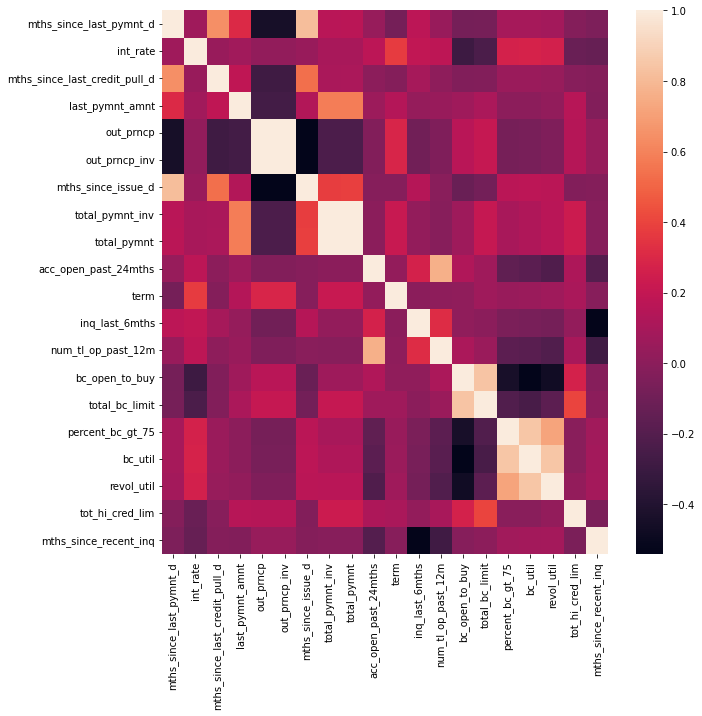

In [130]:
# Capture only the top 20 relevant features
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()

# Calculate the correlations between each pair of featuees
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat);

These features have multicollinearity and should be dropped:

-out_prncp_inv

-total_pymnt_inv

In [131]:
# Drop the features with the least p values (chi squared),and exclude the ones with multicollinearity
# and 2 numerical features with high multicollinearity
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True, errors='ignore')

# apply to X_train
col_to_drop(X_train, drop_columns_list)


## Creating dummy variables (One-Hot Encoding)
**Convet discrete variables to dummy variables**

In [132]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1808534 entries, 1786181 to 677997
Data columns (total 22 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   term                           int64  
 1   int_rate                       float64
 2   grade                          object 
 3   home_ownership                 object 
 4   verification_status            object 
 5   pymnt_plan                     object 
 6   inq_last_6mths                 float64
 7   revol_util                     float64
 8   out_prncp                      float64
 9   total_pymnt                    float64
 10  last_pymnt_amnt                float64
 11  acc_open_past_24mths           float64
 12  bc_open_to_buy                 float64
 13  bc_util                        float64
 14  mths_since_recent_inq          float64
 15  num_tl_op_past_12m             float64
 16  percent_bc_gt_75               float64
 17  tot_hi_cred_lim                float64
 1

In [133]:
X_train

,term,int_rate,grade,home_ownership,verification_status,pymnt_plan,inq_last_6mths,revol_util,out_prncp,total_pymnt,last_pymnt_amnt,acc_open_past_24mths,bc_open_to_buy,bc_util,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
1786181,60,16.29,C,MORTGAGE,Verified,n,2.0,36.4,0.00,44050.099073,733.48,4.0,28739.0,36.4,0.0,2.0,16.7,337998.0,45200.0,106.0,46.0,36.0
1540677,60,16.02,C,MORTGAGE,Source Verified,n,0.0,90.7,12841.78,7750.920000,408.73,0.0,8663.0,90.7,1.0,0.0,85.7,185400.0,93600.0,55.0,36.0,36.0
238639,36,18.94,D,RENT,Verified,n,0.0,44.0,4235.04,1276.650000,183.13,1.0,NaN,NaN,12.0,0.0,NaN,25988.0,0.0,43.0,36.0,36.0
1464444,60,12.62,C,MORTGAGE,Not Verified,n,0.0,39.3,13482.95,6641.640000,391.40,6.0,24864.0,43.6,NaN,3.0,27.3,248585.0,44100.0,53.0,36.0,36.0
1963316,36,14.99,C,RENT,Source Verified,n,0.0,39.0,0.00,4312.770000,205.37,5.0,2367.0,37.0,NaN,1.0,66.7,16150.0,7100.0,90.0,69.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234190,36,8.18,B,MORTGAGE,Not Verified,n,0.0,53.5,0.00,15695.321491,544.51,2.0,11930.0,54.1,NaN,0.0,25.0,262569.0,26000.0,82.0,49.0,49.0
1124732,60,12.69,C,RENT,Source Verified,n,0.0,44.1,0.00,14709.590000,451.90,2.0,7496.0,60.1,23.0,1.0,50.0,87202.0,18800.0,78.0,49.0,43.0
1309084,36,11.44,B,OWN,Not Verified,n,1.0,67.5,0.00,11854.697117,329.26,6.0,1307.0,76.2,4.0,1.0,66.7,36776.0,5500.0,84.0,48.0,39.0
1765757,36,11.14,B,MORTGAGE,Verified,n,0.0,83.9,0.00,5548.760000,2084.42,4.0,910.0,92.4,NaN,1.0,66.7,178574.0,11900.0,104.0,81.0,36.0


In [134]:
# Create function to perform One-Hot Encoding
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# Apply One-Hot Encoding
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status','pymnt_plan'
                                   #, 'purpose'
                                  ])

In [135]:
X_train

,term,int_rate,grade,home_ownership,verification_status,pymnt_plan,inq_last_6mths,revol_util,out_prncp,total_pymnt,last_pymnt_amnt,acc_open_past_24mths,bc_open_to_buy,bc_util,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,pymnt_plan:n,pymnt_plan:y
1786181,60,16.29,C,MORTGAGE,Verified,n,2.0,36.4,0.00,44050.099073,733.48,4.0,28739.0,36.4,0.0,2.0,16.7,337998.0,45200.0,106.0,46.0,36.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
1540677,60,16.02,C,MORTGAGE,Source Verified,n,0.0,90.7,12841.78,7750.920000,408.73,0.0,8663.0,90.7,1.0,0.0,85.7,185400.0,93600.0,55.0,36.0,36.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
238639,36,18.94,D,RENT,Verified,n,0.0,44.0,4235.04,1276.650000,183.13,1.0,NaN,NaN,12.0,0.0,NaN,25988.0,0.0,43.0,36.0,36.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0
1464444,60,12.62,C,MORTGAGE,Not Verified,n,0.0,39.3,13482.95,6641.640000,391.40,6.0,24864.0,43.6,NaN,3.0,27.3,248585.0,44100.0,53.0,36.0,36.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1963316,36,14.99,C,RENT,Source Verified,n,0.0,39.0,0.00,4312.770000,205.37,5.0,2367.0,37.0,NaN,1.0,66.7,16150.0,7100.0,90.0,69.0,60.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234190,36,8.18,B,MORTGAGE,Not Verified,n,0.0,53.5,0.00,15695.321491,544.51,2.0,11930.0,54.1,NaN,0.0,25.0,262569.0,26000.0,82.0,49.0,49.0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1124732,60,12.69,C,RENT,Source Verified,n,0.0,44.1,0.00,14709.590000,451.90,2.0,7496.0,60.1,23.0,1.0,50.0,87202.0,18800.0,78.0,49.0,43.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1309084,36,11.44,B,OWN,Not Verified,n,1.0,67.5,0.00,11854.697117,329.26,6.0,1307.0,76.2,4.0,1.0,66.7,36776.0,5500.0,84.0,48.0,39.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
1765757,36,11.14,B,MORTGAGE,Verified,n,0.0,83.9,0.00,5548.760000,2084.42,4.0,910.0,92.4,NaN,1.0,66.7,178574.0,11900.0,104.0,81.0,36.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


## Update the test data set with all data cleaning procedures performed so far

In [136]:
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status','pymnt_plan'
                                 #, 'purpose'
                                ])

# Use the Re-index function to ensure that the columns in the test dataset are also present in the training dataset
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

C:\Users\I\AppData\Local\Temp/ipykernel_15152/740673079.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('\+ years', '')


In [137]:
X_test

,term,int_rate,grade,home_ownership,verification_status,pymnt_plan,inq_last_6mths,revol_util,out_prncp,total_pymnt,last_pymnt_amnt,acc_open_past_24mths,bc_open_to_buy,bc_util,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,pymnt_plan:n,pymnt_plan:y
1387754,60,23.99,E,MORTGAGE,Source Verified,n,0.0,60.7,0.00,27250.183232,23140.37,2.0,0.0,100.8,6.0,1.0,100.0,225000.0,6800.0,60.0,52.0,45.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0
520162,36,14.49,C,MORTGAGE,Not Verified,n,0.0,10.9,0.00,4424.083958,1880.26,2.0,6482.0,11.2,14.0,1.0,0.0,7500.0,7300.0,65.0,44.0,43.0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2045293,36,21.99,E,RENT,Source Verified,n,0.0,45.4,0.00,7835.563446,217.46,2.0,769.0,87.2,NaN,0.0,50.0,23685.0,6000.0,94.0,58.0,49.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
1639656,36,10.49,B,MORTGAGE,Source Verified,n,0.0,16.2,0.00,15322.888669,10326.38,12.0,46357.0,18.4,14.0,5.0,8.3,311362.0,56800.0,57.0,45.0,45.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
965128,36,9.76,B,OWN,Source Verified,n,0.0,33.3,0.00,11112.968127,614.92,1.0,16680.0,34.1,NaN,1.0,40.0,49100.0,25300.0,74.0,39.0,36.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62633,36,16.14,C,RENT,Source Verified,n,3.0,7.3,32355.78,3599.630000,1220.59,7.0,24225.0,10.6,4.0,3.0,0.0,139490.0,27100.0,39.0,36.0,36.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
217852,36,11.55,B,RENT,Source Verified,n,2.0,30.4,4157.86,1144.930000,158.14,8.0,22591.0,30.7,2.0,4.0,16.7,69480.0,32600.0,43.0,36.0,36.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
209080,36,16.91,C,MORTGAGE,Source Verified,n,2.0,72.0,6930.10,1716.740000,284.87,4.0,3475.0,72.0,0.0,3.0,90.0,408150.0,34750.0,42.0,36.0,36.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
2082268,36,16.99,D,RENT,Verified,n,0.0,54.6,0.00,22412.350014,12930.01,7.0,5553.0,46.1,7.0,5.0,0.0,32467.0,10300.0,96.0,81.0,56.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0


## WoE Binning/Feature Engineering
We will analyze both categorical and numerical features based on their categorical/binned WoEs and IVs and then combine some of these binned categories together through a custom Python Class with fit_transform method

In [101]:
# Make duplicates of the training sets prior to utilizing with Weight of Evidence
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

### Analyze WoEs and IVs of discrete features

In [102]:
# Create a function to determine the Weight of Evidence for discrete data (Categorical)
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**grade**

In [103]:
df_temp = woe_discrete(X_train_prepr, 'grade', y_train_prepr)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,9697,0.602764,0.005362,5845.0,3852.0,0.003697,0.016934,-1.521816,NaN,NaN,0.483175
1,F,33507,0.640314,0.018527,21455.0,12052.0,0.013570,0.052982,-1.362083,0.037550,0.159733,0.483175
2,E,108512,0.721238,0.060000,78263.0,30249.0,0.049500,0.132977,-0.988198,0.080924,0.373885,0.483175
3,D,259341,0.800371,0.143398,207569.0,51772.0,0.131285,0.227594,-0.550195,0.079133,0.438003,0.483175
4,C,519664,0.859985,0.287340,446903.0,72761.0,0.282661,0.319864,-0.123648,0.059614,0.426547,0.483175
5,B,531178,0.915789,0.293706,486447.0,44731.0,0.307672,0.196641,0.447651,0.055805,0.571300,0.483175
6,A,346635,0.965214,0.191666,334577.0,12058.0,0.211616,0.053008,1.384329,0.049425,0.936678,0.483175


**home_ownership**

In [104]:
df_temp = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,137,0.781022,0.000076,107.0,30.0,0.000068,0.000132,-0.667178,NaN,NaN,0.025307
1,NONE,48,0.833333,0.000027,40.0,8.0,0.000025,0.000035,-0.329372,0.052311,0.337806,0.025307
2,RENT,715768,0.853415,0.395772,610847.0,104921.0,0.386353,0.461242,-0.177171,0.020081,0.152201,0.025307
3,OWN,202392,0.874936,0.111909,177080.0,25312.0,0.112001,0.111274,0.006513,0.021521,0.183684,0.025307
4,MORTGAGE,889386,0.890767,0.491772,792236.0,97150.0,0.501079,0.427080,0.159793,0.015832,0.153280,0.025307
5,ANY,803,0.932752,0.000444,749.0,54.0,0.000474,0.000237,0.690945,0.041985,0.531152,0.025307


**verification_status**

In [105]:
df_temp = woe_discrete(X_train_prepr, 'verification_status', y_train_prepr)
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,503917,0.833705,0.278633,420118.0,83799.0,0.265719,0.368388,-0.326695,NaN,NaN,0.08508
1,Source Verified,709404,0.869543,0.392254,616857.0,92547.0,0.390154,0.406845,-0.041889,0.035838,0.284806,0.08508
2,Not Verified,595213,0.914100,0.329114,544084.0,51129.0,0.344126,0.224768,0.425942,0.044557,0.467831,0.08508


**pyment_plan**

In [106]:
df_temp = woe_discrete(X_train_prepr, 'pymnt_plan', y_train_prepr)
df_temp

,pymnt_plan,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,y,551,0.019964,0.000305,11.0,540.0,0.000007,0.002374,-5.832484,NaN,NaN,0.013811
1,n,1807983,0.874482,0.999695,1581048.0,226935.0,0.999993,0.997626,0.002370,0.854518,5.834853,0.013811


Disregard this feature since it has:

-IV value<0.02

### Analyze WoEs and IVs of numeric features

In [ ]:
# Create a function to determine the Weight of Evidence for continuous data, which is similar to the discrete method
# except that there is no need for reseting the index and sorting of values
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

**term**

In [ ]:
df_temp = woe_ordered_continuous(X_train_prepr, 'term', y_train_prepr)
df_temp

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,1287362,0.892822,0.711826,1149385.0,137977.0,0.726972,0.606559,0.181085,NaN,NaN,0.065798
1,60,521172,0.828276,0.288174,431674.0,89498.0,0.273028,0.393441,-0.365355,0.064546,0.546441,0.065798


**int_rate_factor**

In [ ]:
# fine classing
X_train_prepr['int_rate_factor'] = pd.cut(X_train_prepr['int_rate'], 20)
df_temp = woe_ordered_continuous(X_train_prepr, 'int_rate_factor', y_train_prepr)
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.284, 6.594]",99983,0.978646,0.055284,97848.0,2135.0,0.061888,0.009386,1.886139,NaN,NaN,0.449621
1,"(6.594, 7.878]",145963,0.967471,0.080708,141215.0,4748.0,0.089317,0.020873,1.453750,0.011175,0.432389,0.449621
2,"(7.878, 9.162]",154733,0.936006,0.085557,144831.0,9902.0,0.091604,0.043530,0.744021,0.031465,0.709729,0.449621
3,"(9.162, 10.446]",166225,0.931490,0.091911,154837.0,11388.0,0.097932,0.050063,0.671003,0.004515,0.073018,0.449621
4,"(10.446, 11.73]",217977,0.906137,0.120527,197517.0,20460.0,0.124927,0.089944,0.328543,0.025354,0.342460,0.449621
5,"(11.73, 13.014]",201025,0.880363,0.111154,176975.0,24050.0,0.111934,0.105726,0.057064,0.025774,0.271479,0.449621
6,"(13.014, 14.298]",187860,0.862302,0.103874,161992.0,25868.0,0.102458,0.113718,-0.104270,0.018061,0.161333,0.449621
7,"(14.298, 15.582]",142739,0.851183,0.078925,121497.0,21242.0,0.076845,0.093382,-0.194901,0.011119,0.090631,0.449621
8,"(15.582, 16.866]",118746,0.819101,0.065659,97265.0,21481.0,0.061519,0.094432,-0.428539,0.032082,0.233639,0.449621
9,"(16.866, 18.15]",113345,0.804023,0.062672,91132.0,22213.0,0.057640,0.097650,-0.527179,0.015078,0.098639,0.449621


**last_pymnt_amnt**

In [ ]:
# fine classing
X_train_prepr['last_pymnt_amnt'] = pd.cut(X_train_prepr['last_pymnt_amnt'], 20)
df_temp = woe_ordered_continuous(X_train_prepr, 'last_pymnt_amnt', y_train_prepr)
df_temp

,last_pymnt_amnt,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-42.192, 2109.602]",1282605,0.823340,0.709196,1056020.0,226585.0,0.667919,0.996087,-0.399668,NaN,NaN,inf
1,"(2109.602, 4219.205]",106782,0.994756,0.059043,106222.0,560.0,0.067184,0.002462,3.306540,0.171416,3.706207,inf
2,"(4219.205, 6328.808]",89411,0.998926,0.049438,89315.0,96.0,0.056491,0.000422,4.896767,0.004171,1.590227,inf
3,"(6328.808, 8438.41]",70759,0.999350,0.039125,70713.0,46.0,0.044725,0.000202,5.398934,0.000424,0.502167,inf
4,"(8438.41, 10548.012]",59738,0.999130,0.033031,59686.0,52.0,0.037751,0.000229,5.106799,0.000220,0.292134,inf
5,"(10548.012, 12657.615]",45107,0.999490,0.024941,45084.0,23.0,0.028515,0.000101,5.641979,0.000361,0.535179,inf
6,"(12657.615, 14767.217]",36485,0.999260,0.020174,36458.0,27.0,0.023059,0.000119,5.269270,0.000230,0.372709,inf
7,"(14767.217, 16876.82]",28476,0.999403,0.015745,28459.0,17.0,0.018000,0.000075,5.484197,0.000143,0.214927,inf
8,"(16876.82, 18986.422]",21658,0.999400,0.011975,21645.0,13.0,0.013690,0.000057,5.478771,0.000003,0.005426,inf
9,"(18986.422, 21096.025]",17558,0.998747,0.009708,17536.0,22.0,0.011091,0.000097,4.742159,0.000653,0.736612,inf


**out_prncp**

In [ ]:
# fine classing
X_train_prepr['out_prncp'] = pd.cut(X_train_prepr['out_prncp'], 20)
df_temp = woe_ordered_continuous(X_train_prepr, 'out_prncp', y_train_prepr)
df_temp

,out_prncp,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-40.0, 2000.0]",1136674,0.813773,0.628506,924995.0,211679.0,0.585048,0.930559,-0.464092,NaN,NaN,0.779755
1,"(2000.0, 4000.0]",98159,0.978728,0.054275,96071.0,2088.0,0.060764,0.009179,1.890071,0.164955,2.354163,0.779755
2,"(4000.0, 6000.0]",92108,0.978091,0.050930,90090.0,2018.0,0.056981,0.008871,1.859892,0.000637,0.030179,0.779755
3,"(6000.0, 8000.0]",80493,0.977377,0.044507,78672.0,1821.0,0.049759,0.008005,1.827092,0.000714,0.032801,0.779755
4,"(8000.0, 10000.0]",84522,0.977320,0.046735,82605.0,1917.0,0.052247,0.008427,1.824499,0.000057,0.002593,0.779755
5,"(10000.0, 12000.0]",56986,0.976012,0.031509,55619.0,1367.0,0.035178,0.006009,1.767096,0.001308,0.057402,0.779755
6,"(12000.0, 14000.0]",49597,0.974575,0.027424,48336.0,1261.0,0.030572,0.005543,1.707462,0.001437,0.059635,0.779755
7,"(14000.0, 16000.0]",40089,0.974781,0.022167,39078.0,1011.0,0.024716,0.004444,1.715810,0.000206,0.008348,0.779755
8,"(16000.0, 18000.0]",31970,0.973944,0.017677,31137.0,833.0,0.019694,0.003662,1.682309,0.000837,0.033501,0.779755
9,"(18000.0, 20000.0]",30012,0.973044,0.016595,29203.0,809.0,0.018471,0.003556,1.647418,0.000900,0.034891,0.779755


Disregard this feature since it has:

-Suspiciously high IV value

**total_pymnt**

In [ ]:
# fine classing
X_train_prepr['total_pymnt'] = pd.cut(X_train_prepr['total_pymnt'], 20)
df_temp = woe_ordered_continuous(X_train_prepr, 'total_pymnt', y_train_prepr)
df_temp

,total_pymnt,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-63.297, 3164.844]",330262,0.846349,0.182613,279517.0,50745.0,0.176791,0.223079,-0.232560,NaN,NaN,0.26258
1,"(3164.844, 6329.688]",338954,0.820111,0.187419,277980.0,60974.0,0.175819,0.268047,-0.421708,0.026238,0.189148,0.26258
2,"(6329.688, 9494.532]",266894,0.838284,0.147575,223733.0,43161.0,0.141508,0.189740,-0.293294,0.018173,0.128414,0.26258
3,"(9494.532, 12659.376]",225011,0.878015,0.124416,197563.0,27448.0,0.124956,0.120664,0.034954,0.039731,0.328248,0.26258
4,"(12659.376, 15824.219]",155159,0.888901,0.085793,137921.0,17238.0,0.087233,0.075780,0.140755,0.010886,0.105801,0.26258
5,"(15824.219, 18989.063]",129287,0.918051,0.071487,118692.0,10595.0,0.075071,0.046577,0.477340,0.029149,0.336585,0.26258
6,"(18989.063, 22153.907]",92364,0.927223,0.051071,85642.0,6722.0,0.054167,0.029551,0.605980,0.009172,0.128640,0.26258
7,"(22153.907, 25318.751]",74240,0.945097,0.041050,70164.0,4076.0,0.044378,0.017918,0.906909,0.017874,0.300929,0.26258
8,"(25318.751, 28483.595]",57244,0.954615,0.031652,54646.0,2598.0,0.034563,0.011421,1.107324,0.009518,0.200415,0.26258
9,"(28483.595, 31648.439]",40285,0.960084,0.022275,38677.0,1608.0,0.024463,0.007069,1.241444,0.005469,0.134120,0.26258


**acc_open_past_24mths**

In [ ]:
# fine classing
X_train_prepr['acc_open_past_24mths'] = pd.cut(X_train_prepr['acc_open_past_24mths'], 20)
df_temp = woe_ordered_continuous(X_train_prepr, 'acc_open_past_24mths', y_train_prepr)
df_temp

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,acc_open_past_24mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.064, 3.2]",768439,0.904631,4.344866e-01,695154.0,73285.0,4.492844e-01,0.331057,0.305367,NaN,NaN,inf
1,"(3.2, 6.4]",613769,0.867310,3.470339e-01,532328.0,81441.0,3.440485e-01,0.367900,-0.067030,0.037321,0.372396,inf
2,"(6.4, 9.6]",263424,0.836317,1.489437e-01,220306.0,43118.0,1.423858e-01,0.194781,-0.313334,0.030993,0.246304,inf
3,"(9.6, 12.8]",84570,0.814343,4.781710e-02,68869.0,15701.0,4.451067e-02,0.070927,-0.465929,0.021974,0.152595,inf
4,"(12.8, 16.0]",29260,0.797061,1.654403e-02,23322.0,5938.0,1.507322e-02,0.026824,-0.576386,0.017282,0.110457,inf
5,"(16.0, 19.2]",5753,0.798018,3.252830e-03,4591.0,1162.0,2.967206e-03,0.005249,-0.570455,0.000958,0.005930,inf
6,"(19.2, 22.4]",2012,0.784294,1.137614e-03,1578.0,434.0,1.019876e-03,0.001961,-0.653542,0.013724,0.083086,inf
7,"(22.4, 25.6]",772,0.788860,4.365000e-04,609.0,163.0,3.936023e-04,0.000736,-0.626342,0.004566,0.027199,inf
8,"(25.6, 28.8]",322,0.819876,1.820635e-04,264.0,58.0,1.706256e-04,0.000262,-0.428904,0.031016,0.197438,inf
9,"(28.8, 32.0]",167,0.814371,9.442422e-05,136.0,31.0,8.789805e-05,0.000140,-0.465743,0.005505,0.036838,inf


**inq_last_6mths**

In [ ]:
# fine classing
X_train_prepr['inq_last_6mths'] = pd.cut(X_train_prepr['inq_last_6mths'], 20)
df_temp = woe_ordered_continuous(X_train_prepr, 'inq_last_6mths', y_train_prepr)
df_temp

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.032, 1.6]",1573002,0.883155,8.697788e-01,1389205.0,183797.0,8.786675e-01,0.807998,0.083847,NaN,NaN,inf
1,"(1.6, 3.2]",215280,0.820160,1.190374e-01,176564.0,38716.0,1.116761e-01,0.170201,-0.421378,0.062995,0.505225,inf
2,"(3.2, 4.8]",13907,0.759617,7.689764e-03,10564.0,3343.0,6.681695e-03,0.014696,-0.788225,0.060542,0.366847,inf
3,"(4.8, 6.4]",5972,0.750000,3.302170e-03,4479.0,1493.0,2.832953e-03,0.006563,-0.840196,0.009617,0.051971,inf
4,"(6.4, 8.0]",234,0.632479,1.293884e-04,148.0,86.0,9.360951e-05,0.000378,-1.395943,0.117521,0.555747,inf
5,"(8.0, 9.6]",38,0.605263,2.101180e-05,23.0,15.0,1.454742e-05,0.000066,-1.511364,0.027215,0.115421,inf
6,"(9.6, 11.2]",31,0.870968,1.714120e-05,27.0,4.0,1.707741e-05,0.000018,-0.029266,0.265705,1.482098,inf
7,"(11.2, 12.8]",11,0.727273,6.082362e-06,8.0,3.0,5.059973e-06,0.000013,-0.957979,0.143695,0.928713,inf
8,"(12.8, 14.4]",11,0.363636,6.082362e-06,4.0,7.0,2.529987e-06,0.000031,-2.498424,0.363636,1.540445,inf
9,"(14.4, 16.0]",9,0.666667,4.976478e-06,6.0,3.0,3.794980e-06,0.000013,-1.245661,0.303030,1.252763,inf


**revol_util**

In [ ]:
# fine classing
X_train_prepr['revol_util'] = pd.cut(X_train_prepr['revol_util'], 20)
df_temp = woe_ordered_continuous(X_train_prepr, 'revol_util', y_train_prepr)
df_temp

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,revol_util,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.892, 44.615]",764048,0.896568,4.228048e-01,685021.0,79027.0,4.336185e-01,0.347653,0.220961,NaN,NaN,inf
1,"(44.615, 89.23]",931966,0.859590,5.157264e-01,801109.0,130857.0,5.071023e-01,0.575661,-0.126807,0.036978,0.347768,inf
2,"(89.23, 133.845]",111028,0.843112,6.144008e-02,93609.0,17419.0,5.925453e-02,0.076629,-0.257134,0.016479,0.130327,inf
3,"(133.845, 178.46]",44,0.772727,2.434848e-05,34.0,10.0,2.152201e-05,0.000044,-0.714923,0.070384,0.457790,inf
4,"(178.46, 223.075]",6,0.666667,3.320248e-06,4.0,2.0,2.532001e-06,0.000009,-1.245551,0.106061,0.530628,inf
5,"(223.075, 267.69]",0,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(267.69, 312.305]",0,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(312.305, 356.92]",0,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(356.92, 401.535]",1,0.000000,5.533746e-07,0.0,1.0,0.000000e+00,0.000004,-inf,NaN,NaN,inf
9,"(401.535, 446.15]",0,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


**num_tl_op_past_12m**

In [ ]:
# fine classing
X_train_prepr['num_tl_op_past_12m'] = pd.cut(X_train_prepr['num_tl_op_past_12m'], 20)

df_temp = woe_ordered_continuous(X_train_prepr, 'num_tl_op_past_12m', y_train_prepr)
df_temp

,num_tl_op_past_12m,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.032, 1.6]",779915,0.902089,0.445069,703553.0,76362.0,4.587190e-01,0.349305,0.272491,NaN,NaN,inf
1,"(1.6, 3.2]",655209,0.865087,0.373904,566813.0,88396.0,3.695641e-01,0.404353,-0.089964,0.037002,0.362455,inf
2,"(3.2, 4.8]",156220,0.836730,0.089149,130714.0,25506.0,8.522599e-02,0.116673,-0.314069,0.028357,0.224105,inf
3,"(4.8, 6.4]",116668,0.830331,0.066578,96873.0,19795.0,6.316154e-02,0.090549,-0.360195,0.006400,0.046127,inf
4,"(6.4, 8.0]",31183,0.812366,0.017795,25332.0,5851.0,1.651655e-02,0.026764,-0.482711,0.017965,0.122516,inf
5,"(8.0, 9.6]",5711,0.797759,0.003259,4556.0,1155.0,2.970528e-03,0.005283,-0.575822,0.014607,0.093111,inf
6,"(9.6, 11.2]",4841,0.804792,0.002763,3896.0,945.0,2.540206e-03,0.004323,-0.531646,0.007034,0.044176,inf
7,"(11.2, 12.8]",1019,0.784102,0.000582,799.0,220.0,5.209508e-04,0.001006,-0.658433,0.020690,0.126787,inf
8,"(12.8, 14.4]",949,0.748156,0.000542,710.0,239.0,4.629225e-04,0.001093,-0.859365,0.035946,0.200932,inf
9,"(14.4, 16.0]",363,0.782369,0.000207,284.0,79.0,1.851690e-04,0.000361,-0.668640,0.034213,0.190725,inf


**bc_open_to_buy**

In [ ]:
# fine classing
X_train_prepr['bc_open_to_buy'] = pd.cut(X_train_prepr['bc_open_to_buy'], 20)

df_temp = woe_ordered_continuous(X_train_prepr, 'bc_open_to_buy', y_train_prepr)
df_temp

,bc_open_to_buy,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-711.14, 35557.0]",1622610,0.869762,9.279157e-01,1411284.0,211326.0,9.224784e-01,0.965938,-0.046036,NaN,NaN,inf
1,"(35557.0, 71114.0]",101339,0.938336,5.795234e-02,95090.0,6249.0,6.215508e-02,0.028563,0.777513,0.068574,0.823549,inf
2,"(71114.0, 106671.0]",18573,0.951112,1.062127e-02,17665.0,908.0,1.154663e-02,0.004150,1.023207,0.012776,0.245694,inf
3,"(106671.0, 142228.0]",4333,0.950842,2.477896e-03,4120.0,213.0,2.693016e-03,0.000974,1.017427,0.000269,0.005780,inf
4,"(142228.0, 177785.0]",1182,0.956007,6.759458e-04,1130.0,52.0,7.386186e-04,0.000238,1.133840,0.005164,0.116413,inf
5,"(177785.0, 213342.0]",377,0.960212,2.155935e-04,362.0,15.0,2.366194e-04,0.000069,1.238705,0.004205,0.104865,inf
6,"(213342.0, 248899.0]",144,0.951389,8.234872e-05,137.0,7.0,8.954933e-05,0.000032,1.029182,0.008823,0.209523,inf
7,"(248899.0, 284456.0]",62,0.919355,3.545570e-05,57.0,5.0,3.725775e-05,0.000023,0.488724,0.032034,0.540457,inf
8,"(284456.0, 320013.0]",13,0.846154,7.434260e-06,11.0,2.0,7.190092e-06,0.000009,-0.240141,0.073201,0.728865,inf
9,"(320013.0, 355570.0]",15,0.933333,8.577992e-06,14.0,1.0,9.151027e-06,0.000005,0.694168,0.087179,0.934309,inf


**total_bc_limit**

In [ ]:
# fine classing
X_train_prepr['total_bc_limit'] = pd.cut(X_train_prepr['total_bc_limit'], 20)

df_temp = woe_ordered_continuous(X_train_prepr, 'total_bc_limit', y_train_prepr)
df_temp

,total_bc_limit,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-1105.5, 55275.0]",1623382,0.869893,9.178837e-01,1412168.0,211214.0,9.126972e-01,0.954135,-0.044401,NaN,NaN,inf
1,"(55275.0, 110550.0]",127794,0.928502,7.225658e-02,118657.0,9137.0,7.668911e-02,0.041275,0.619494,0.058610,0.663895,inf
2,"(110550.0, 165825.0]",14568,0.940486,8.236958e-03,13701.0,867.0,8.855083e-03,0.003917,0.815775,0.011984,0.196280,inf
3,"(165825.0, 221100.0]",2211,0.947987,1.250131e-03,2096.0,115.0,1.354664e-03,0.000519,0.958443,0.007501,0.142669,inf
4,"(221100.0, 276375.0]",485,0.952577,2.742260e-04,462.0,23.0,2.985949e-04,0.000104,1.055660,0.004590,0.097217,inf
5,"(276375.0, 331650.0]",108,0.953704,6.106477e-05,103.0,5.0,6.656985e-05,0.000023,1.080881,0.001126,0.025220,inf
6,"(331650.0, 386925.0]",37,0.891892,2.092034e-05,33.0,4.0,2.132820e-05,0.000018,0.165803,0.061812,0.915078,inf
7,"(386925.0, 442200.0]",10,1.000000,5.654145e-06,10.0,0.0,6.463092e-06,0.000000,inf,0.108108,inf,inf
8,"(442200.0, 497475.0]",6,1.000000,3.392487e-06,6.0,0.0,3.877855e-06,0.000000,inf,0.000000,NaN,inf
9,"(497475.0, 552750.0]",3,1.000000,1.696243e-06,3.0,0.0,1.938928e-06,0.000000,inf,0.000000,NaN,inf


**percent_bc_gt_75**

In [ ]:
# fine classing
X_train_prepr['percent_bc_gt_75'] = pd.cut(X_train_prepr['percent_bc_gt_75'], 20)

df_temp = woe_ordered_continuous(X_train_prepr, 'percent_bc_gt_75', y_train_prepr)
df_temp

,percent_bc_gt_75,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.1, 5.0]",480332,0.909213,0.274740,436724.0,43608.0,0.285516,0.199379,0.359089,NaN,NaN,0.057871
1,"(5.0, 10.0]",17422,0.900585,0.009965,15690.0,1732.0,0.010258,0.007919,0.258775,0.008627,0.100314,0.057871
2,"(10.0, 15.0]",46334,0.892671,0.026502,41361.0,4973.0,0.027040,0.022737,0.173343,0.007915,0.085432,0.057871
3,"(15.0, 20.0]",90465,0.887813,0.051744,80316.0,10149.0,0.052508,0.046402,0.123622,0.004858,0.049721,0.057871
4,"(20.0, 25.0]",87382,0.884152,0.049981,77259.0,10123.0,0.050509,0.046283,0.087382,0.003661,0.036240,0.057871
5,"(25.0, 30.0]",24370,0.876159,0.013939,21352.0,3018.0,0.013959,0.013799,0.011579,0.007993,0.075802,0.057871
6,"(30.0, 35.0]",118853,0.877622,0.067981,104308.0,14545.0,0.068193,0.066501,0.025129,0.001463,0.013550,0.057871
7,"(35.0, 40.0]",56856,0.866065,0.032520,49241.0,7615.0,0.032192,0.034816,-0.078365,0.011557,0.103494,0.057871
8,"(40.0, 45.0]",20695,0.862189,0.011837,17843.0,2852.0,0.011665,0.013040,-0.111381,0.003876,0.033016,0.057871
9,"(45.0, 50.0]",187738,0.866793,0.107382,162730.0,25008.0,0.106387,0.114338,-0.072075,0.004604,0.039306,0.057871


**bc_util**

In [ ]:
# fine classing
X_train_prepr['bc_util'] = pd.cut(X_train_prepr['bc_util'], 20)

df_temp = woe_ordered_continuous(X_train_prepr, 'bc_util', y_train_prepr)
df_temp

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,bc_util,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.34, 16.98]",179750,0.910865,1.028464e-01,163728.0,16022.0,1.070733e-01,0.073283,0.379181,NaN,NaN,inf
1,"(16.98, 33.96]",234599,0.905626,1.342290e-01,212459.0,22140.0,1.389419e-01,0.101267,0.316300,0.005239,0.062881,inf
2,"(33.96, 50.94]",290471,0.888653,1.661969e-01,258128.0,32343.0,1.688081e-01,0.147934,0.131995,0.016973,0.184305,inf
3,"(50.94, 67.92]",313240,0.873541,1.792245e-01,273628.0,39612.0,1.789446e-01,0.181182,-0.012426,0.015112,0.144421,inf
4,"(67.92, 84.9]",329858,0.862320,1.887327e-01,284443.0,45415.0,1.860173e-01,0.207724,-0.110373,0.011222,0.097947,inf
5,"(84.9, 101.88]",392083,0.843199,2.243356e-01,330604.0,61479.0,2.162053e-01,0.281200,-0.262837,0.019121,0.152465,inf
6,"(101.88, 118.86]",7234,0.790434,4.139031e-03,5718.0,1516.0,3.739403e-03,0.006934,-0.617519,0.052765,0.354682,inf
7,"(118.86, 135.84]",364,0.810440,2.082675e-04,295.0,69.0,1.929213e-04,0.000316,-0.492194,0.020005,0.125325,inf
8,"(135.84, 152.82]",78,0.782051,4.462876e-05,61.0,17.0,3.989220e-05,0.000078,-0.667402,0.028388,0.175208,inf
9,"(152.82, 169.8]",33,0.818182,1.888140e-05,27.0,6.0,1.765720e-05,0.000027,-0.440986,0.036131,0.226417,inf


**tot_hi_cred_lim**

In [ ]:
# fine classing
X_train_prepr['tot_hi_cred_lim'] = pd.cut(X_train_prepr['tot_hi_cred_lim'], 20)

df_temp = woe_ordered_continuous(X_train_prepr, 'tot_hi_cred_lim', y_train_prepr)
df_temp

,tot_hi_cred_lim,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-9999.999, 499999.95]",1658241,0.872384,9.462982e-01,1446623.0,211618.0,9.432033e-01,0.968012,-0.025962,NaN,NaN,inf
1,"(499999.95, 999999.9]",87237,0.924149,4.978301e-02,80620.0,6617.0,5.256453e-02,0.030268,0.551938,0.051765,0.577900,inf
2,"(999999.9, 1499999.85]",5522,0.942774,3.151206e-03,5206.0,316.0,3.394330e-03,0.001445,0.853658,0.018625,0.301720,inf
3,"(1499999.85, 1999999.8]",881,0.948922,5.027549e-04,836.0,45.0,5.450750e-04,0.000206,0.973799,0.006147,0.120141,inf
4,"(1999999.8, 2499999.75]",278,0.974820,1.586446e-04,271.0,7.0,1.766930e-04,0.000032,1.708042,0.025898,0.734243,inf
5,"(2499999.75, 2999999.7]",107,0.971963,6.106104e-05,104.0,3.0,6.780837e-05,0.000014,1.597612,0.002858,0.110430,inf
6,"(2999999.7, 3499999.65]",29,0.931034,1.654925e-05,27.0,2.0,1.760410e-05,0.000009,0.654523,0.040928,0.943089,inf
7,"(3499999.65, 3999999.6]",16,0.937500,9.130622e-06,15.0,1.0,9.780053e-06,0.000005,0.759884,0.006466,0.105361,inf
8,"(3999999.6, 4499999.55]",11,1.000000,6.277303e-06,11.0,0.0,7.172039e-06,0.000000,inf,0.062500,inf,inf
9,"(4499999.55, 4999999.5]",4,1.000000,2.282656e-06,4.0,0.0,2.608014e-06,0.000000,inf,0.000000,NaN,inf


**mths_since_last_pymnt_d_factor**

In [ ]:
# fine classing
X_train_prepr['mths_since_last_pymnt_d_factor'] = pd.cut(X_train_prepr['mths_since_last_pymnt_d'], 20)

df_temp = woe_ordered_continuous(X_train_prepr, "mths_since_last_pymnt_d_factor", y_train_prepr)
df_temp

,mths_since_last_pymnt_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(35.866, 42.7]",931874,0.963437,0.515810,897802.0,34072.0,0.567849,0.151052,1.324227,NaN,NaN,0.846998
1,"(42.7, 49.4]",191697,0.813550,0.106108,155955.0,35742.0,0.098640,0.158456,-0.474005,0.149888,1.798233,0.846998
2,"(49.4, 56.1]",167078,0.780372,0.092481,130383.0,36695.0,0.082466,0.162681,-0.679410,0.033177,0.205405,0.846998
3,"(56.1, 62.8]",128379,0.778336,0.071060,99922.0,28457.0,0.063199,0.126159,-0.691251,0.002036,0.011840,0.846998
4,"(62.8, 69.5]",120281,0.735877,0.066578,88512.0,31769.0,0.055983,0.140843,-0.922599,0.042459,0.231349,0.846998
5,"(69.5, 76.2]",92280,0.783127,0.051079,72267.0,20013.0,0.045708,0.088724,-0.663261,0.047251,0.259338,0.846998
6,"(76.2, 82.9]",60307,0.781667,0.033381,47140.0,13167.0,0.029815,0.058374,-0.671838,0.001460,0.008577,0.846998
7,"(82.9, 89.6]",44793,0.787154,0.024794,35259.0,9534.0,0.022301,0.042267,-0.639390,0.005487,0.032448,0.846998
8,"(89.6, 96.3]",28557,0.782190,0.015807,22337.0,6220.0,0.014128,0.027575,-0.668772,0.004964,0.029382,0.846998
9,"(96.3, 103.0]",15634,0.747857,0.008654,11692.0,3942.0,0.007395,0.017476,-0.860030,0.034333,0.191258,0.846998


Disregard this feature since it has:

-Suspiciously high IV value

**mths_since_last_credit_pull_d**

In [ ]:
# fine-classing
X_train_prepr['mths_since_last_credit_pull_d'] = pd.cut(X_train_prepr['mths_since_last_credit_pull_d'], 20)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, "mths_since_last_credit_pull_d", y_train_prepr)
df_temp

,mths_since_last_credit_pull_d,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(34.858, 42.1]",1368312,0.921803,0.756611,1261314.0,106998.0,0.797791,0.470389,0.528286,NaN,NaN,inf
1,"(42.1, 49.2]",150692,0.793705,0.083325,119605.0,31087.0,0.075651,0.136666,-0.591408,0.128098,1.119694,inf
2,"(49.2, 56.3]",99814,0.712756,0.055192,71143.0,28671.0,0.044998,0.126045,-1.030008,0.080949,0.438599,inf
3,"(56.3, 63.4]",73052,0.634247,0.040394,46333.0,26719.0,0.029306,0.117463,-1.388334,0.078509,0.358326,inf
4,"(63.4, 70.5]",61374,0.478541,0.033937,29370.0,32004.0,0.018577,0.140697,-2.024701,0.155705,0.636367,inf
5,"(70.5, 77.6]",20188,0.968348,0.011163,19549.0,639.0,0.012365,0.002809,1.481962,0.489806,3.506662,inf
6,"(77.6, 84.7]",12734,0.963955,0.007041,12275.0,459.0,0.007764,0.002018,1.347456,0.004393,0.134505,inf
7,"(84.7, 91.8]",7792,0.956109,0.004309,7450.0,342.0,0.004712,0.001504,1.142345,0.007846,0.205111,inf
8,"(91.8, 98.9]",5113,0.958537,0.002827,4901.0,212.0,0.003100,0.000932,1.201795,0.002428,0.059450,inf
9,"(98.9, 106.0]",3435,0.964774,0.001899,3314.0,121.0,0.002096,0.000532,1.371307,0.006237,0.169512,inf


**mths_since_issue_d**

In [ ]:
# fine-classing
X_train_prepr['mths_since_issue_d'] = pd.cut(X_train_prepr['mths_since_issue_d'], 20)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, "mths_since_issue_d", y_train_prepr)
df_temp

,mths_since_issue_d,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(37.862, 44.9]",238551,0.987013,0.131903,235453.0,3098.0,0.148921,0.013619,2.391945,NaN,NaN,0.492347
1,"(44.9, 51.8]",222148,0.944830,0.122833,209892.0,12256.0,0.132754,0.053878,0.901768,0.042184,1.490177,0.492347
2,"(51.8, 58.7]",213195,0.897624,0.117883,191369.0,21826.0,0.121038,0.095949,0.232292,0.047205,0.669476,0.492347
3,"(58.7, 65.6]",182915,0.864440,0.101140,158119.0,24796.0,0.100008,0.109005,-0.086144,0.033184,0.318436,0.492347
4,"(65.6, 72.5]",216455,0.826541,0.119685,178909.0,37546.0,0.113158,0.165056,-0.377499,0.037898,0.291355,0.492347
5,"(72.5, 79.4]",218436,0.820629,0.120781,179255.0,39181.0,0.113377,0.172243,-0.418192,0.005912,0.040693,0.492347
6,"(79.4, 86.3]",151999,0.815538,0.084045,123961.0,28038.0,0.078404,0.123258,-0.452404,0.005091,0.034211,0.492347
7,"(86.3, 93.2]",127188,0.819865,0.070327,104277.0,22911.0,0.065954,0.100719,-0.423376,0.004327,0.029027,0.492347
8,"(93.2, 100.1]",88282,0.836954,0.048814,73888.0,14394.0,0.046733,0.063277,-0.303071,0.017089,0.120305,0.492347
9,"(100.1, 107.0]",61035,0.842451,0.033748,51419.0,9616.0,0.032522,0.042273,-0.262230,0.005497,0.040840,0.492347


**mths_since_recent_inq**

In [ ]:
# fine-classing
X_train_prepr['mths_since_recent_inq'] = pd.cut(X_train_prepr['mths_since_recent_inq'], 20)
# preprocess
df_temp = woe_ordered_continuous(X_train_prepr, "mths_since_recent_inq", y_train_prepr)
df_temp

,mths_since_recent_inq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.025, 1.25]",305474,0.835092,0.194303,255099.0,50375.0,0.186613,0.245545,-0.274445,NaN,NaN,0.038242
1,"(1.25, 2.5]",138749,0.852388,0.088254,118268.0,20481.0,0.086517,0.099831,-0.143146,0.017296,0.131299,0.038242
2,"(2.5, 3.75]",125942,0.858467,0.080108,108117.0,17825.0,0.079091,0.086885,-0.093990,0.006078,0.049156,0.038242
3,"(3.75, 5.0]",217483,0.868748,0.138334,188938.0,28545.0,0.138214,0.139138,-0.006665,0.010282,0.087325,0.038242
4,"(5.0, 6.25]",91611,0.872930,0.058271,79970.0,11641.0,0.058500,0.056742,0.030517,0.004182,0.037181,0.038242
5,"(6.25, 7.5]",87391,0.876692,0.055587,76615.0,10776.0,0.056046,0.052526,0.064870,0.003762,0.034353,0.038242
6,"(7.5, 8.75]",77274,0.877798,0.049152,67831.0,9443.0,0.049620,0.046028,0.075144,0.001106,0.010274,0.038242
7,"(8.75, 10.0]",128308,0.883343,0.081613,113340.0,14968.0,0.082912,0.072959,0.127876,0.005545,0.052732,0.038242
8,"(10.0, 11.25]",54413,0.890045,0.034610,48430.0,5983.0,0.035428,0.029163,0.194596,0.006701,0.066720,0.038242
9,"(11.25, 12.5]",49398,0.890461,0.031421,43987.0,5411.0,0.032178,0.026375,0.198859,0.000416,0.004263,0.038242


### Define Custom Class for WoE Binning/Reengineering

Here we will create a custom scikit-learn class to take care of all binning transformations on any given data set. This custom class will help us in performing k fold cross validation

In [23]:

# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['int_rate:>20.718','last_pymnt_amnt:>12657.615','total_pymnt:>28483.595','acc_open_past_24mths:>9.6',
                  'inq_last_6mths:>1.6','revol_util:>44.615','num_tl_op_past_12m:>4.8','bc_open_to_buy:>35557.0','total_bc_limit:>55275.0',
                  'percent_bc_gt_75:>95.0','bc_util:>84.9','tot_hi_cred_lim:>499999.95','mths_since_last_credit_pull_d:>56.3',
                  'mths_since_issue_d:>93.2','mths_since_recent_inq:>18.75','grade:E_F_G']
# !!!!!
#This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:,['grade:A']]
        X_new['grade:B']=X.loc[:,['grade:B']]
        X_new['grade:C']=X.loc[:,['grade:C']]
        X_new['grade:D']=X.loc[:,['grade:D']]
        X_new['grade:E_F_G']=sum([X['grade:E'], X['grade:F'], X['grade:G']])

        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE_ANY'] = sum([X['home_ownership:MORTGAGE'], X['home_ownership:ANY']])
        
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Verified':'verification_status:Not Verified']], axis = 1)
                    
        X_new['int_rate:missing'] = np.where(X['int_rate'].isnull(), 1, 0)
        X_new['int_rate:<6.594'] = np.where((X['int_rate'] <= 6.594), 1, 0)
        X_new['int_rate:6.594-7.878'] = np.where((X['int_rate'] > 6.594) & (X['int_rate'] <= 7.878), 1, 0)
        X_new['int_rate:7.878- 9.162'] = np.where((X['int_rate'] > 7.878) & (X['int_rate'] <= 9.162), 1, 0)
        X_new['int_rate:9.162-10.446'] = np.where((X['int_rate'] > 9.162) & (X['int_rate'] <= 10.446), 1, 0)
        X_new['int_rate:10.446-11.73'] = np.where((X['int_rate'] > 10.446) & (X['int_rate'] <= 11.73), 1, 0)
        X_new['int_rate:11.73-13.014'] = np.where((X['int_rate'] > 11.73) & (X['int_rate'] <= 13.014), 1, 0)
        X_new['int_rate:13.014-14.298'] = np.where((X['int_rate'] > 13.014) & (X['int_rate'] <= 14.298), 1, 0)
        X_new['int_rate:14.298-15.582'] = np.where((X['int_rate'] > 14.298) & (X['int_rate'] <= 15.582), 1, 0)
        X_new['int_rate:15.582-16.866'] = np.where((X['int_rate'] > 15.582) & (X['int_rate'] <= 16.866), 1, 0)
        X_new['int_rate:16.866-18.15'] = np.where((X['int_rate'] > 16.866) & (X['int_rate'] <= 18.15), 1, 0)
        X_new['int_rate:18.15-20.718'] = np.where((X['int_rate'] > 18.15) & (X['int_rate'] <= 20.718), 1, 0)
        X_new['int_rate:>20.718'] = np.where((X['int_rate'] >20.718), 1, 0)

        
        X_new['last_pymnt_amnt:missing'] = np.where(X['last_pymnt_amnt'].isnull(), 1, 0)
        X_new['last_pymnt_amnt:<2109.602'] = np.where((X['last_pymnt_amnt'] <= 2109.602), 1, 0)
        X_new['last_pymnt_amnt:2109.602-4219.205'] = np.where((X['last_pymnt_amnt'] > 2109.602) & (X['last_pymnt_amnt'] <= 4219.205), 1, 0)
        X_new['last_pymnt_amnt:4219.205-8438.41'] = np.where((X['last_pymnt_amnt'] > 4219.205) & (X['last_pymnt_amnt'] <= 8438.41), 1, 0)
        X_new['last_pymnt_amnt:8438.41-12657.615'] = np.where((X['last_pymnt_amnt'] > 8438.41) & (X['last_pymnt_amnt'] <= 12657.615), 1, 0)
        X_new['last_pymnt_amnt:>12657.615'] = np.where((X['last_pymnt_amnt'] >12657.615), 1, 0)
        
        X_new['total_pymnt:missing'] = np.where(X['total_pymnt'].isnull(), 1, 0)
        X_new['total_pymnt:<3164.844'] = np.where((X['total_pymnt'] <= 3164.844), 1, 0)
        X_new['total_pymnt:3164.844-6329.688'] = np.where((X['total_pymnt'] > 3164.844) & (X['total_pymnt'] <= 6329.688), 1, 0)
        X_new['total_pymnt:6329.688]-9494.532'] = np.where((X['total_pymnt'] > 6329.688) & (X['total_pymnt'] <= 9494.532), 1, 0)
        X_new['total_pymnt:9494.532-12659.376'] = np.where((X['total_pymnt'] > 9494.532) & (X['total_pymnt'] <= 12659.376), 1, 0)
        X_new['total_pymnt:12659.376-15824.219'] = np.where((X['total_pymnt'] > 12659.376) & (X['total_pymnt'] <= 15824.219), 1, 0)
        X_new['total_pymnt:15824.219-18989.063'] = np.where((X['total_pymnt'] > 15824.219) & (X['total_pymnt'] <= 18989.063), 1, 0)
        X_new['total_pymnt:18989.063-22153.907'] = np.where((X['total_pymnt'] > 18989.063) & (X['total_pymnt'] <= 22153.907), 1, 0)
        X_new['total_pymnt:22153.907-28483.595'] = np.where((X['total_pymnt'] > 22153.907) & (X['total_pymnt'] <= 28483.595), 1, 0)
        X_new['total_pymnt:>28483.595'] = np.where((X['total_pymnt'] > 28483.595), 1, 0)
        
        X_new['acc_open_past_24mths:missing'] = np.where(X['acc_open_past_24mths'].isnull(), 1, 0)
        X_new['acc_open_past_24mths:<3.2'] = np.where((X['acc_open_past_24mths'] <= 3.2), 1, 0)
        X_new['acc_open_past_24mths:3.2-6.4]'] = np.where((X['acc_open_past_24mths'] > 3.2) & (X['acc_open_past_24mths'] <= 6.4), 1, 0)
        X_new['acc_open_past_24mths:6.4-9.6]'] = np.where((X['acc_open_past_24mths'] > 6.4) & (X['acc_open_past_24mths'] <= 9.6), 1, 0)
        X_new['acc_open_past_24mths:>9.6'] = np.where((X['acc_open_past_24mths'] >9.6 ), 1, 0)
        
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:<1.6'] = np.where((X['inq_last_6mths'] <= 1.6), 1, 0)
        X_new['inq_last_6mths:>1.6'] = np.where((X['inq_last_6mths'] >1.6), 1, 0)
        
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<44.615'] = np.where((X['revol_util'] <= 44.615), 1, 0)
        X_new['revol_util:>44.615'] = np.where((X['revol_util'] > 44.615), 1, 0)
        
        X_new['num_tl_op_past_12m:missing'] = np.where(X['num_tl_op_past_12m'].isnull(), 1, 0)
        X_new['num_tl_op_past_12m:<1.6'] = np.where((X['num_tl_op_past_12m'] <= 1.6), 1, 0)
        X_new['num_tl_op_past_12m:1.6-3.2'] = np.where((X['num_tl_op_past_12m'] > 1.6) & (X['num_tl_op_past_12m'] <= 3.2), 1, 0)
        X_new['num_tl_op_past_12m:3.2-4.8'] = np.where((X['num_tl_op_past_12m'] > 3.2) & (X['num_tl_op_past_12m'] <= 4.8), 1, 0)
        X_new['num_tl_op_past_12m:>4.8'] = np.where((X['num_tl_op_past_12m'] > 4.8), 1, 0)
        
        X_new['bc_open_to_buy:missing'] = np.where(X['bc_open_to_buy'].isnull(), 1, 0)
        X_new['bc_open_to_buy:<35557.0'] = np.where((X['bc_open_to_buy'] <= 35557.0), 1, 0)
        X_new['bc_open_to_buy:>35557.0'] = np.where((X['bc_open_to_buy'] > 35557.0), 1, 0)
        
        X_new['total_bc_limit:missing'] = np.where(X['total_bc_limit'].isnull(), 1, 0)
        X_new['total_bc_limit:<55275.0'] = np.where((X['total_bc_limit'] <= 55275.0), 1, 0)
        X_new['total_bc_limit:>55275.0'] = np.where((X['total_bc_limit'] > 55275.0), 1, 0)
        
        
        X_new['percent_bc_gt_75:missing'] = np.where(X['percent_bc_gt_75'].isnull(), 1, 0)
        X_new['percent_bc_gt_75:<5.0'] = np.where((X['percent_bc_gt_75'] <= 5.0), 1, 0)
        X_new['percent_bc_gt_75:5.0-15.0]'] = np.where((X['percent_bc_gt_75'] > 5.0) & (X['percent_bc_gt_75'] <= 15.0), 1, 0)
        X_new['percent_bc_gt_75:15.0-20.0]'] = np.where((X['percent_bc_gt_75'] > 15.0) & (X['percent_bc_gt_75'] <= 20.0), 1, 0)
        X_new['percent_bc_gt_75:20.0-30.0]'] = np.where((X['percent_bc_gt_75'] > 20.0) & (X['percent_bc_gt_75'] <= 30.0), 1, 0)
        X_new['percent_bc_gt_75:30.0-35.0]'] = np.where((X['percent_bc_gt_75'] > 30.0) & (X['percent_bc_gt_75'] <= 35.0), 1, 0)
        X_new['percent_bc_gt_75:35.0-50.0]'] = np.where((X['percent_bc_gt_75'] > 35.0) & (X['percent_bc_gt_75'] <= 50.0), 1, 0)
        X_new['percent_bc_gt_75:50.0-70.0]'] = np.where((X['percent_bc_gt_75'] > 50.0) & (X['percent_bc_gt_75'] <= 70.0), 1, 0)
        X_new['percent_bc_gt_75:>70.0]'] = np.where((X['percent_bc_gt_75'] > 20.0) & (X['percent_bc_gt_75'] <= 30.0), 1, 0)
        X_new['percent_bc_gt_75:70.0-95.0]'] = np.where((X['percent_bc_gt_75'] > 70.0) & (X['percent_bc_gt_75'] <= 95.0), 1, 0)
        X_new['percent_bc_gt_75:>95.0'] = np.where((X['percent_bc_gt_75'] >95.0 ), 1, 0)
                
        X_new['bc_util:missing'] = np.where(X['bc_util'].isnull(), 1, 0)
        X_new['bc_util:<16.98'] = np.where((X['bc_util'] <= 16.98), 1, 0)
        X_new['bc_util:16.98-33.96'] = np.where((X['bc_util'] > 16.98) & (X['bc_util'] <= 33.96), 1, 0)
        X_new['bc_util:33.96-50.94'] = np.where((X['bc_util'] > 33.96) & (X['bc_util'] <= 50.94), 1, 0)
        X_new['bc_util:50.94-67.92'] = np.where((X['bc_util'] > 50.94) & (X['bc_util'] <= 67.92), 1, 0)
        X_new['bc_util:67.92-84.9'] = np.where((X['bc_util'] > 67.92) & (X['bc_util'] <= 84.9), 1, 0)
        X_new['bc_util:>84.9'] = np.where((X['bc_util'] > 84.9), 1, 0)
        
        X_new['tot_hi_cred_lim:missing'] = np.where(X['tot_hi_cred_lim'].isnull(), 1, 0)
        X_new['tot_hi_cred_lim:<499999.95'] = np.where((X['tot_hi_cred_lim'] <= 499999.95), 1, 0)
        X_new['tot_hi_cred_lim:>499999.95'] = np.where((X['tot_hi_cred_lim'] > 499999.95), 1, 0)
        
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<42.1'] = np.where((X['mths_since_last_credit_pull_d'] <= 42.1), 1, 0)
        X_new['mths_since_last_credit_pull_d:42.1-49.2'] = np.where((X['mths_since_last_credit_pull_d'] > 42.1) & (X['mths_since_last_credit_pull_d'] <= 49.2), 1, 0)
        X_new['mths_since_last_credit_pull_d:49.2-56.3'] = np.where((X['mths_since_last_credit_pull_d'] > 49.2) & (X['mths_since_last_credit_pull_d'] <= 56.3), 1, 0)
        X_new['mths_since_last_credit_pull_d:>56.3'] = np.where((X['mths_since_last_credit_pull_d'] > 56.3), 1, 0)
    
        X_new['mths_since_issue_d:missing'] = np.where(X['mths_since_issue_d'].isnull(), 1, 0)
        X_new['mths_since_issue_d:<44.9'] = np.where((X['mths_since_issue_d'] <= 44.9), 1, 0)
        X_new['mths_since_issue_d:44.9-51.8'] = np.where((X['mths_since_issue_d'] > 44.9) & (X['mths_since_issue_d'] <= 51.8), 1, 0)
        X_new['mths_since_issue_d:51.8-58.7'] = np.where((X['mths_since_issue_d'] > 51.8) & (X['mths_since_issue_d'] <= 58.7), 1, 0)
        X_new['mths_since_issue_d:58.7-65.6'] = np.where((X['mths_since_issue_d'] > 58.7) & (X['mths_since_issue_d'] <= 65.6), 1, 0)
        X_new['mths_since_issue_d:65.6-72.5'] = np.where((X['mths_since_issue_d'] > 65.6) & (X['mths_since_issue_d'] <= 72.5), 1, 0)
        X_new['mths_since_issue_d:72.5-79.4'] = np.where((X['mths_since_issue_d'] > 72.5) & (X['mths_since_issue_d'] <= 79.4), 1, 0)
        X_new['mths_since_issue_d:79.4-86.3'] = np.where((X['mths_since_issue_d'] > 79.4) & (X['mths_since_issue_d'] <= 86.3), 1, 0)
        X_new['mths_since_issue_d:86.3-93.2'] = np.where((X['mths_since_issue_d'] > 86.3) & (X['mths_since_issue_d'] <= 93.2), 1, 0)
        X_new['mths_since_issue_d:>93.2'] = np.where((X['mths_since_issue_d'] > 93.2), 1, 0)
        
        X_new['mths_since_recent_inq:missing'] = np.where(X['mths_since_recent_inq'].isnull(), 1, 0)
        X_new['mths_since_recent_inq:<1.25'] = np.where((X['mths_since_recent_inq'] <= 1.25), 1, 0)
        X_new['mths_since_recent_inq:1.25-2.5'] = np.where((X['mths_since_recent_inq'] > 1.25) & (X['mths_since_recent_inq'] <= 2.5), 1, 0)
        X_new['mths_since_recent_inq:2.5-3.75'] = np.where((X['mths_since_recent_inq'] > 2.5) & (X['mths_since_recent_inq'] <= 3.75), 1, 0)
        X_new['mths_since_recent_inq:3.75-5.0'] = np.where((X['mths_since_recent_inq'] > 3.75) & (X['mths_since_recent_inq'] <= 5.0), 1, 0)
        X_new['mths_since_recent_inq:5.0-6.25'] = np.where((X['mths_since_recent_inq'] > 5.0) & (X['mths_since_recent_inq'] <= 6.25), 1, 0)
        X_new['mths_since_recent_inq:6.25-7.5'] = np.where((X['mths_since_recent_inq'] > 6.25) & (X['mths_since_recent_inq'] <= 7.5), 1, 0)
        X_new['mths_since_recent_inq:7.5-10.0'] = np.where((X['mths_since_recent_inq'] > 7.5) & (X['mths_since_recent_inq'] <= 10.0), 1, 0)
        X_new['mths_since_recent_inq:10.0-12.5'] = np.where((X['mths_since_recent_inq'] > 10.0) & (X['mths_since_recent_inq'] <= 12.5), 1, 0)
        X_new['mths_since_recent_inq:12.5-15.0'] = np.where((X['mths_since_recent_inq'] > 12.5) & (X['mths_since_recent_inq'] <= 15.0), 1, 0)
        X_new['mths_since_recent_inq:15.0-18.75'] = np.where((X['mths_since_recent_inq'] > 15.0) & (X['mths_since_recent_inq'] <= 18.75), 1, 0)
        X_new['mths_since_recent_inq:>18.75'] = np.where((X['mths_since_recent_inq'] > 18.75), 1, 0)
        
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new
# we could have also structured this class without the last drop statement and without creating categories out of the 
# feature categories. But doing the way we have done here allows us to keep a proper track of the categories, if required

# PD Model

In [7]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1808534, 40)
(1808534, 1)
(452134, 40)
(452134, 1)


# Export to CSV

In [ ]:
X_train.to_csv("X_train.csv", encoding='utf-8', index=False)
y_train.to_csv("y_train.csv", encoding='utf-8', index=False)
X_test.to_csv("X_test.csv", encoding='utf-8', index=False)
y_test.to_csv("y_test.csv", encoding='utf-8', index=False)
X.to_csv("X.csv", encoding='utf-8', index=False)

# Import Training, Testing dataset and X.csv

In [44]:
import pandas as pd
X_train = pd.read_csv('../continue/X_train.csv')
y_train = pd.read_csv('../continue/y_train.csv')
X_test = pd.read_csv('../continue/X_test.csv')
y_test = pd.read_csv('../continue/y_test.csv')
X = pd.read_csv('../continue/X.csv')

# (START) GridSearch CV

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [6]:
sc = StandardScaler()
reg = LogisticRegression(max_iter=1000)
woe_transform = WoE_Binning(X)
pipelineScal = Pipeline(steps=[('woe', woe_transform),('sca',sc),('model',reg)])
param = {
    "model__penalty":['l2'],
    "model__solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "model__C": np.logspace(-4, 4, 4)
}
# define grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_searchScal = GridSearchCV(estimator=pipelineScal, param_grid=param, n_jobs=1, 
                               cv=cv, scoring='roc_auc',error_score=0)
grid_resultScal = grid_searchScal.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_resultScal.best_score_, grid_resultScal.best_params_))
means = grid_resultScal.cv_results_['mean_test_score']
stds = grid_resultScal.cv_results_['std_test_score']
params = grid_resultScal.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f | STD: %f | Parameter: %r" % (mean, stdev, param))

#source: https://blog.dominodatalab.com/hyperopt-bayesian-hyperparameter-optimization

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramDa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did n

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Best: 0.907945 using {'model__C': 10000.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Mean: 0.903589 | STD: 0.000884 | Parameter: {'model__C': 0.0001, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Mean: 0.903589 | STD: 0.000884 | Parameter: {'model__C': 0.0001, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Mean: 0.902024 | STD: 0.000890 | Parameter: {'model__C': 0.0001, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Mean: 0.907934 | STD: 0.000824 | Parameter: {'model__C': 0.046415888336127774, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Mean: 0.907935 | STD: 0.000824 | Parameter: {'model__C': 0.046415888336127774, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Mean: 0.907925 | STD: 0.000824 | Parameter: {'model__C': 0.046415888336127774, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Mean: 0.907945 | STD: 0.000824 | Parameter: {'model__C': 21.54434690031882, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Mean: 0.907945 | STD: 0.00082

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np

reg = LogisticRegression(max_iter=1000)
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform),('model',reg)])
param = {
    "model__penalty":['l2'],
    "model__solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "model__C": np.logspace(-4, 4, 4)
}
# define grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param, n_jobs=1, 
                           cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f | STD: %f | Parameter: %r" % (mean, stdev, param))
    
#source: https://blog.dominodatalab.com/hyperopt-bayesian-hyperparameter-optimization

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did n

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Best: 0.907945 using {'model__C': 21.54434690031882, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Mean: 0.890831 | STD: 0.001003 | Parameter: {'model__C': 0.0001, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Mean: 0.890832 | STD: 0.001004 | Parameter: {'model__C': 0.0001, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Mean: 0.888294 | STD: 0.001019 | Parameter: {'model__C': 0.0001, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Mean: 0.907858 | STD: 0.000824 | Parameter: {'model__C': 0.046415888336127774, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Mean: 0.907858 | STD: 0.000823 | Parameter: {'model__C': 0.046415888336127774, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Mean: 0.907849 | STD: 0.000825 | Parameter: {'model__C': 0.046415888336127774, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Mean: 0.907945 | STD: 0.000824 | Parameter: {'model__C': 21.54434690031882, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Mean: 0.907945 | ST

# (END) GridSearchCV

# (START) Confusion Matrix Comparison (Pipeline 1,3)

In [8]:
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,10),dpi=1000)


sc = StandardScaler()
reg = LogisticRegression()


woe_transform = WoE_Binning(X)
print("binning done")
pipeline = Pipeline(steps=[('woe', woe_transform), ('model',reg)])
#Fit pipeline (models)
pipeline.fit(X_train,y_train)
print("fit done")
# Make the confusion matrix of LG Model
from sklearn.metrics import confusion_matrix
y_pred=pipeline.predict(X_test)
print("predict done")
cf_matrix = confusion_matrix(y_test, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', annot_kws={"fontsize":18}, fmt='g',ax=ax1)
sns.set(font_scale = 2)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
ax1.set_title("LG (No Scalar)")

pipelineScalar = Pipeline(steps=[('woe', woe_transform),('scale',sc), ('model',reg)])
#Fit pipeline (models)
pipelineScalar.fit(X_train,y_train)
print("fit done")
y_predLG=pipelineScalar.predict(X_test)
print("predict done")
# Make the confusion matrix of LG Model
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_predLG)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', annot_kws={"fontsize":18}, fmt='g',ax=ax2)
sns.set(font_scale = 1)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
ax2.set_title("LG & Scalar")

binning done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fit done
predict done

Test confusion_matrix


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fit done
predict done

Test confusion_matrix


Text(0.5, 1.0, 'LG & Scalar')

# (END) Confusion Matrix Comparison (Pipeline 1,3)

# (START) ROC Curve and TPR/FPR (Pipeline 1,3)

In [9]:
def getFPRTPR(pipeline):
    # get the predicted probabilities
    y_hat_test_probaLG = pipeline.predict_proba(X_test)
    # select the probabilities of only the positive class (class 1 - default) 
    y_hat_test_probaLG = y_hat_test_probaLG[:][: , 1]

    # we will now create a new DF with actual classes and the predicted probabilities
    # create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
    y_test_tempLG = y_test.copy()
    y_test_tempLG.reset_index(drop = True, inplace = True)
    y_test_probaLG = pd.concat([y_test_tempLG, pd.DataFrame(y_hat_test_probaLG)], axis = 1)

    # Rename the columns
    y_test_probaLG.columns = ['y_test_class_actual', 'y_hat_test_proba']
    # Makes the index of one dataframe equal to the index of another dataframe.
    y_test_probaLG.index = X_test.index

    # assign a threshold value to differentiate good with bad
    tr = 0.5
    # crate a new column for the predicted class based on predicted probabilities and threshold
    # We will determine this optimat threshold later in this project
    y_test_probaLG['y_test_class_predicted'] = np.where(y_test_probaLG['y_hat_test_proba'] > tr, 1, 0)

    # get the values required to plot a ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_probaLG['y_test_class_actual'], y_test_probaLG['y_hat_test_proba'])

    return tpr,fpr

tprUntunedScaler,fprUntunedScaler = getFPRTPR(pipelineScalar)
tprUntuned,fprUntuned = getFPRTPR(pipeline)

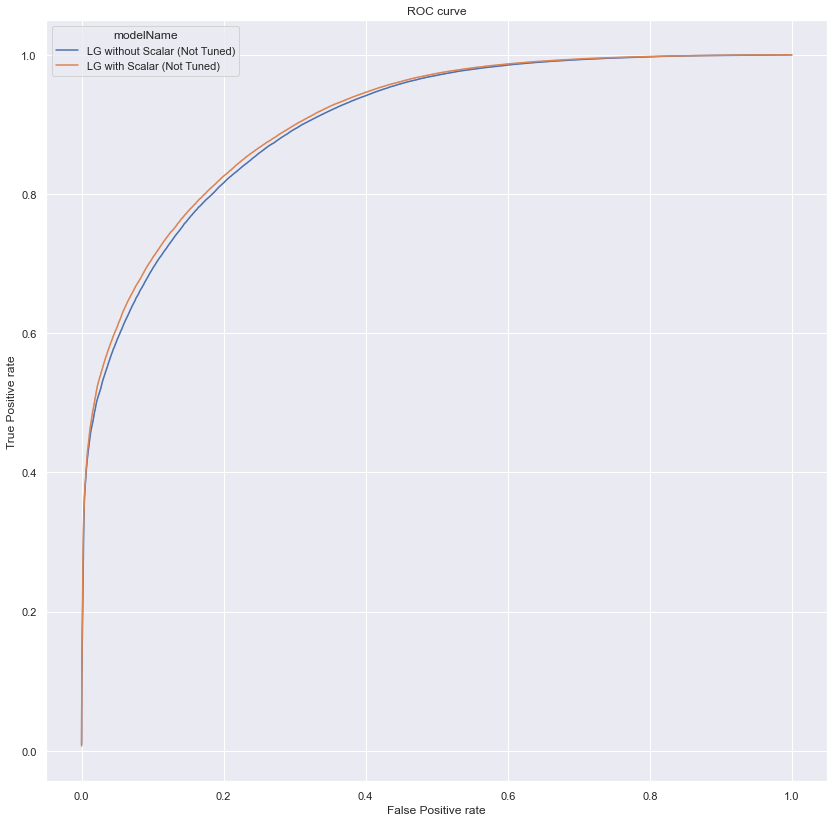

In [10]:
from matplotlib.pylab import rcParams

positiveUntuned= pd.DataFrame({'fpr':fprUntuned,'tpr':tprUntuned,'modelName':'LG without Scalar (Not Tuned)'})

positiveScalerUntuned=pd.DataFrame({'fpr':fprUntunedScaler,'tpr':tprUntunedScaler,'modelName':'LG with Scalar (Not Tuned)'})

rcParams['figure.figsize'] = 14,14
sns.lineplot(x='fpr', y='tpr', data=pd.concat([positiveUntuned,positiveScalerUntuned]).reset_index(), hue='modelName')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve');

# (END) ROC Curve and TPR/FPR (Pipeline 1,3)

# (START) Confusion Matrix Comparison (Pipeline 2,4)

In [11]:
from matplotlib.pyplot import figure
# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,10),dpi=1000)

woe_transform = WoE_Binning(X)
print("binning done")
pipelineTuned = Pipeline(steps=[('woe', woe_transform), ('model',LogisticRegression(max_iter=1000, C=21.54434690031882,
                                                            penalty='l2',solver='lbfgs'))])
#Fit pipeline (models)
pipelineTuned.fit(X_train,y_train)
print("fit done")
# Make the confusion matrix of LG Model
from sklearn.metrics import confusion_matrix
y_pred=pipelineTuned.predict(X_test)
print("predict done")
cf_matrix = confusion_matrix(y_test, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', annot_kws={"fontsize":18}, fmt='g',ax=ax1)
sns.set(font_scale = 2)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
ax1.set_title("LG (No Scalar) Tuned")


pipelineScalarTuned = Pipeline(steps=[('woe', woe_transform),('scale',sc), ('model',LogisticRegression(max_iter=1000, C=10000.0,
                                                            penalty='l2',solver='lbfgs'))])
#Fit pipeline (models)
pipelineScalarTuned.fit(X_train,y_train)
print("fit done")
y_predLG=pipelineScalarTuned.predict(X_test)
print("predict done")
# Make the confusion matrix of LG Model
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_predLG)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', annot_kws={"fontsize":18}, fmt='g',ax=ax2)
sns.set(font_scale = 1)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
ax2.set_title("LG & Scalar Tuned")

binning done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


fit done
predict done

Test confusion_matrix


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


fit done
predict done

Test confusion_matrix


Text(0.5, 1.0, 'LG & Scalar Tuned')

# (END) Confusion Matrix Comparison (Pipeline 2,4)

# (START) ROC Curve and TPR/FPR (Pipeline 2,4)

In [30]:
def getFPRTPR(pipeline):
    # get the predicted probabilities
    y_hat_test_probaLG = pipeline.predict_proba(X_test)
    # select the probabilities of only the positive class (class 1 - default) 
    y_hat_test_probaLG = y_hat_test_probaLG[:][: , 1]

    # we will now create a new DF with actual classes and the predicted probabilities
    # create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
    y_test_tempLG = y_test.copy()
    y_test_tempLG.reset_index(drop = True, inplace = True)
    y_test_probaLG = pd.concat([y_test_tempLG, pd.DataFrame(y_hat_test_probaLG)], axis = 1)

    # Rename the columns
    y_test_probaLG.columns = ['y_test_class_actual', 'y_hat_test_proba']
    # Makes the index of one dataframe equal to the index of another dataframe.
    y_test_probaLG.index = X_test.index

    # assign a threshold value to differentiate good with bad
    tr = 0.5
    # crate a new column for the predicted class based on predicted probabilities and threshold
    # We will determine this optimat threshold later in this project
    y_test_probaLG['y_test_class_predicted'] = np.where(y_test_probaLG['y_hat_test_proba'] > tr, 1, 0)

    # get the values required to plot a ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_probaLG['y_test_class_actual'], y_test_probaLG['y_hat_test_proba'])

    return tpr,fpr

tprTuned,fprTuned = getFPRTPR(pipelineTuned)
tprScalerTuned,fprScalerTuned = getFPRTPR(pipelineScalarTuned)

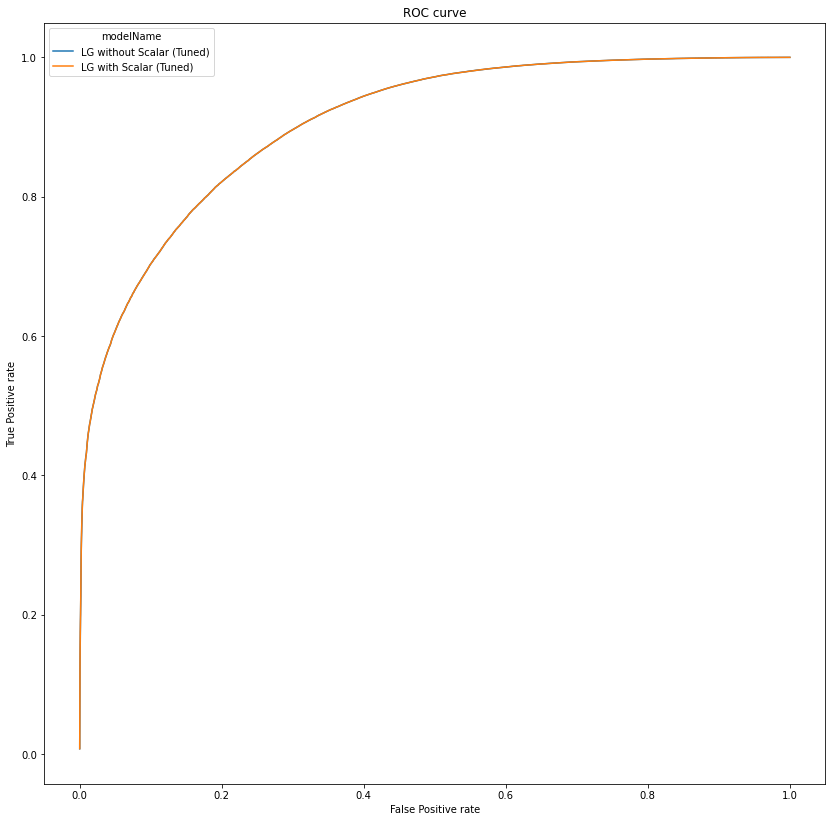

In [31]:
from matplotlib.pylab import rcParams

positiveTuned= pd.DataFrame({'fpr':fprTuned,'tpr':tprTuned,'modelName':'LG without Scalar (Tuned)'})

positiveScalerTuned=pd.DataFrame({'fpr':fprScalerTuned,'tpr':tprScalerTuned,'modelName':'LG with Scalar (Tuned)'})

rcParams['figure.figsize'] = 14,14
sns.lineplot(x='fpr', y='tpr', data=pd.concat([positiveTuned,positiveScalerTuned]).reset_index(), hue='modelName')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve');

# (END) ROC Curve and TPR/FPR (Pipeline 2,4)

# (START) 4 Pipelines' AUROC & GINI Scores

In [16]:
pd.options.mode.chained_assignment = 'warn'
def AUC_Gini(pipeline):
    
    #attain scores based on Cross-Validation settings with Repeated Stratification K-Fold
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
    
    #get mean of the results/scores
    AUROC = np.mean(scores)
    GINI = AUROC * 2 - 1
    
    return AUROC, GINI

'''
fourPipes:
Pipeline 1: LG Only (Not Tuned)
Pipeline 2: LG Only (Tuned)
Pipeline 3: LG & scaler(Not Tuned)
Pipeline 4: LG & scaler(Tuned)
'''
fourPipes= [pipeline,pipelineTuned,pipelineScalar,pipelineScalarTuned]
fourGINI=[]
fourAUCROC=[]

for pipe in fourPipes:
    aucroc,gini = AUC_Gini(pipe)
    fourGINI.append(gini)
    fourAUCROC.append(aucroc)

print ("Pipeline 1 LG Only (Not Tuned)-> GINI:",fourGINI[0]," | AUC/ROC:",fourAUCROC[0])
print ("Pipeline 2 LG Only (Tuned)-> GINI:",fourGINI[1]," | AUC/ROC:",fourAUCROC[1])
print ("Pipeline 3 LG & scaler(Not Tuned)-> GINI:",fourGINI[2]," | AUC/ROC:",fourAUCROC[2])
print ("Pipeline 4 LG & scaler(Tuned)-> GINI:",fourGINI[3]," | AUC/ROC:",fourAUCROC[3])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Pipeline 1 LG Only (Not Tuned)-> GINI: 0.8158713758013114  | AUC/ROC: 0.9079356879006557
Pipeline 2 LG Only (Tuned)-> GINI: 0.8158900854661821  | AUC/ROC: 0.9079450427330911
Pipeline 3 LG & scaler(Not Tuned)-> GINI: 0.8158908685747437  | AUC/ROC: 0.9079454342873718
Pipeline 4 LG & scaler(Tuned)-> GINI: 0.8158908685747437  | AUC/ROC: 0.9079454342873718


# (END) 4 Pipelines' AUROC & GINI Scores

# Export Ideally Tuned Model (Pickle)

In [30]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
woe_transform = WoE_Binning(X)
pipelineTunedScaled = Pipeline(steps=[('woe', woe_transform),('scale',sc), ('model',LogisticRegression(max_iter=1000, C=10000.0,
                                                            penalty='l2',solver='lbfgs'))])

In [56]:
import joblib
joblib.dump(pipelineTunedScaled,'pipeline4.pkl')

['pipeline4.pkl']

# Import Ideally Tuned Model (Pickle) & Libraries 

In [28]:
# Import the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [29]:

# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['int_rate:>20.718','last_pymnt_amnt:>12657.615','total_pymnt:>28483.595','acc_open_past_24mths:>9.6',
                  'inq_last_6mths:>1.6','revol_util:>44.615','num_tl_op_past_12m:>4.8','bc_open_to_buy:>35557.0','total_bc_limit:>55275.0',
                  'percent_bc_gt_75:>95.0','bc_util:>84.9','tot_hi_cred_lim:>499999.95','mths_since_last_credit_pull_d:>56.3',
                  'mths_since_issue_d:>93.2','mths_since_recent_inq:>18.75','grade:E_F_G']
# !!!!!
#This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:,['grade:A']]
        X_new['grade:B']=X.loc[:,['grade:B']]
        X_new['grade:C']=X.loc[:,['grade:C']]
        X_new['grade:D']=X.loc[:,['grade:D']]
        X_new['grade:E_F_G']=sum([X['grade:E'], X['grade:F'], X['grade:G']])

        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE_ANY'] = sum([X['home_ownership:MORTGAGE'], X['home_ownership:ANY']])
        
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Verified':'verification_status:Not Verified']], axis = 1)
                    
        X_new['int_rate:missing'] = np.where(X['int_rate'].isnull(), 1, 0)
        X_new['int_rate:<6.594'] = np.where((X['int_rate'] <= 6.594), 1, 0)
        X_new['int_rate:6.594-7.878'] = np.where((X['int_rate'] > 6.594) & (X['int_rate'] <= 7.878), 1, 0)
        X_new['int_rate:7.878- 9.162'] = np.where((X['int_rate'] > 7.878) & (X['int_rate'] <= 9.162), 1, 0)
        X_new['int_rate:9.162-10.446'] = np.where((X['int_rate'] > 9.162) & (X['int_rate'] <= 10.446), 1, 0)
        X_new['int_rate:10.446-11.73'] = np.where((X['int_rate'] > 10.446) & (X['int_rate'] <= 11.73), 1, 0)
        X_new['int_rate:11.73-13.014'] = np.where((X['int_rate'] > 11.73) & (X['int_rate'] <= 13.014), 1, 0)
        X_new['int_rate:13.014-14.298'] = np.where((X['int_rate'] > 13.014) & (X['int_rate'] <= 14.298), 1, 0)
        X_new['int_rate:14.298-15.582'] = np.where((X['int_rate'] > 14.298) & (X['int_rate'] <= 15.582), 1, 0)
        X_new['int_rate:15.582-16.866'] = np.where((X['int_rate'] > 15.582) & (X['int_rate'] <= 16.866), 1, 0)
        X_new['int_rate:16.866-18.15'] = np.where((X['int_rate'] > 16.866) & (X['int_rate'] <= 18.15), 1, 0)
        X_new['int_rate:18.15-20.718'] = np.where((X['int_rate'] > 18.15) & (X['int_rate'] <= 20.718), 1, 0)
        X_new['int_rate:>20.718'] = np.where((X['int_rate'] >20.718), 1, 0)

        
        X_new['last_pymnt_amnt:missing'] = np.where(X['last_pymnt_amnt'].isnull(), 1, 0)
        X_new['last_pymnt_amnt:<2109.602'] = np.where((X['last_pymnt_amnt'] <= 2109.602), 1, 0)
        X_new['last_pymnt_amnt:2109.602-4219.205'] = np.where((X['last_pymnt_amnt'] > 2109.602) & (X['last_pymnt_amnt'] <= 4219.205), 1, 0)
        X_new['last_pymnt_amnt:4219.205-8438.41'] = np.where((X['last_pymnt_amnt'] > 4219.205) & (X['last_pymnt_amnt'] <= 8438.41), 1, 0)
        X_new['last_pymnt_amnt:8438.41-12657.615'] = np.where((X['last_pymnt_amnt'] > 8438.41) & (X['last_pymnt_amnt'] <= 12657.615), 1, 0)
        X_new['last_pymnt_amnt:>12657.615'] = np.where((X['last_pymnt_amnt'] >12657.615), 1, 0)
        
        X_new['total_pymnt:missing'] = np.where(X['total_pymnt'].isnull(), 1, 0)
        X_new['total_pymnt:<3164.844'] = np.where((X['total_pymnt'] <= 3164.844), 1, 0)
        X_new['total_pymnt:3164.844-6329.688'] = np.where((X['total_pymnt'] > 3164.844) & (X['total_pymnt'] <= 6329.688), 1, 0)
        X_new['total_pymnt:6329.688]-9494.532'] = np.where((X['total_pymnt'] > 6329.688) & (X['total_pymnt'] <= 9494.532), 1, 0)
        X_new['total_pymnt:9494.532-12659.376'] = np.where((X['total_pymnt'] > 9494.532) & (X['total_pymnt'] <= 12659.376), 1, 0)
        X_new['total_pymnt:12659.376-15824.219'] = np.where((X['total_pymnt'] > 12659.376) & (X['total_pymnt'] <= 15824.219), 1, 0)
        X_new['total_pymnt:15824.219-18989.063'] = np.where((X['total_pymnt'] > 15824.219) & (X['total_pymnt'] <= 18989.063), 1, 0)
        X_new['total_pymnt:18989.063-22153.907'] = np.where((X['total_pymnt'] > 18989.063) & (X['total_pymnt'] <= 22153.907), 1, 0)
        X_new['total_pymnt:22153.907-28483.595'] = np.where((X['total_pymnt'] > 22153.907) & (X['total_pymnt'] <= 28483.595), 1, 0)
        X_new['total_pymnt:>28483.595'] = np.where((X['total_pymnt'] > 28483.595), 1, 0)
        
        X_new['acc_open_past_24mths:missing'] = np.where(X['acc_open_past_24mths'].isnull(), 1, 0)
        X_new['acc_open_past_24mths:<3.2'] = np.where((X['acc_open_past_24mths'] <= 3.2), 1, 0)
        X_new['acc_open_past_24mths:3.2-6.4]'] = np.where((X['acc_open_past_24mths'] > 3.2) & (X['acc_open_past_24mths'] <= 6.4), 1, 0)
        X_new['acc_open_past_24mths:6.4-9.6]'] = np.where((X['acc_open_past_24mths'] > 6.4) & (X['acc_open_past_24mths'] <= 9.6), 1, 0)
        X_new['acc_open_past_24mths:>9.6'] = np.where((X['acc_open_past_24mths'] >9.6 ), 1, 0)
        
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:<1.6'] = np.where((X['inq_last_6mths'] <= 1.6), 1, 0)
        X_new['inq_last_6mths:>1.6'] = np.where((X['inq_last_6mths'] >1.6), 1, 0)
        
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<44.615'] = np.where((X['revol_util'] <= 44.615), 1, 0)
        X_new['revol_util:>44.615'] = np.where((X['revol_util'] > 44.615), 1, 0)
        
        X_new['num_tl_op_past_12m:missing'] = np.where(X['num_tl_op_past_12m'].isnull(), 1, 0)
        X_new['num_tl_op_past_12m:<1.6'] = np.where((X['num_tl_op_past_12m'] <= 1.6), 1, 0)
        X_new['num_tl_op_past_12m:1.6-3.2'] = np.where((X['num_tl_op_past_12m'] > 1.6) & (X['num_tl_op_past_12m'] <= 3.2), 1, 0)
        X_new['num_tl_op_past_12m:3.2-4.8'] = np.where((X['num_tl_op_past_12m'] > 3.2) & (X['num_tl_op_past_12m'] <= 4.8), 1, 0)
        X_new['num_tl_op_past_12m:>4.8'] = np.where((X['num_tl_op_past_12m'] > 4.8), 1, 0)
        
        X_new['bc_open_to_buy:missing'] = np.where(X['bc_open_to_buy'].isnull(), 1, 0)
        X_new['bc_open_to_buy:<35557.0'] = np.where((X['bc_open_to_buy'] <= 35557.0), 1, 0)
        X_new['bc_open_to_buy:>35557.0'] = np.where((X['bc_open_to_buy'] > 35557.0), 1, 0)
        
        X_new['total_bc_limit:missing'] = np.where(X['total_bc_limit'].isnull(), 1, 0)
        X_new['total_bc_limit:<55275.0'] = np.where((X['total_bc_limit'] <= 55275.0), 1, 0)
        X_new['total_bc_limit:>55275.0'] = np.where((X['total_bc_limit'] > 55275.0), 1, 0)
        
        
        X_new['percent_bc_gt_75:missing'] = np.where(X['percent_bc_gt_75'].isnull(), 1, 0)
        X_new['percent_bc_gt_75:<5.0'] = np.where((X['percent_bc_gt_75'] <= 5.0), 1, 0)
        X_new['percent_bc_gt_75:5.0-15.0]'] = np.where((X['percent_bc_gt_75'] > 5.0) & (X['percent_bc_gt_75'] <= 15.0), 1, 0)
        X_new['percent_bc_gt_75:15.0-20.0]'] = np.where((X['percent_bc_gt_75'] > 15.0) & (X['percent_bc_gt_75'] <= 20.0), 1, 0)
        X_new['percent_bc_gt_75:20.0-30.0]'] = np.where((X['percent_bc_gt_75'] > 20.0) & (X['percent_bc_gt_75'] <= 30.0), 1, 0)
        X_new['percent_bc_gt_75:30.0-35.0]'] = np.where((X['percent_bc_gt_75'] > 30.0) & (X['percent_bc_gt_75'] <= 35.0), 1, 0)
        X_new['percent_bc_gt_75:35.0-50.0]'] = np.where((X['percent_bc_gt_75'] > 35.0) & (X['percent_bc_gt_75'] <= 50.0), 1, 0)
        X_new['percent_bc_gt_75:50.0-70.0]'] = np.where((X['percent_bc_gt_75'] > 50.0) & (X['percent_bc_gt_75'] <= 70.0), 1, 0)
        X_new['percent_bc_gt_75:>70.0]'] = np.where((X['percent_bc_gt_75'] > 20.0) & (X['percent_bc_gt_75'] <= 30.0), 1, 0)
        X_new['percent_bc_gt_75:70.0-95.0]'] = np.where((X['percent_bc_gt_75'] > 70.0) & (X['percent_bc_gt_75'] <= 95.0), 1, 0)
        X_new['percent_bc_gt_75:>95.0'] = np.where((X['percent_bc_gt_75'] >95.0 ), 1, 0)
                
        X_new['bc_util:missing'] = np.where(X['bc_util'].isnull(), 1, 0)
        X_new['bc_util:<16.98'] = np.where((X['bc_util'] <= 16.98), 1, 0)
        X_new['bc_util:16.98-33.96'] = np.where((X['bc_util'] > 16.98) & (X['bc_util'] <= 33.96), 1, 0)
        X_new['bc_util:33.96-50.94'] = np.where((X['bc_util'] > 33.96) & (X['bc_util'] <= 50.94), 1, 0)
        X_new['bc_util:50.94-67.92'] = np.where((X['bc_util'] > 50.94) & (X['bc_util'] <= 67.92), 1, 0)
        X_new['bc_util:67.92-84.9'] = np.where((X['bc_util'] > 67.92) & (X['bc_util'] <= 84.9), 1, 0)
        X_new['bc_util:>84.9'] = np.where((X['bc_util'] > 84.9), 1, 0)
        
        X_new['tot_hi_cred_lim:missing'] = np.where(X['tot_hi_cred_lim'].isnull(), 1, 0)
        X_new['tot_hi_cred_lim:<499999.95'] = np.where((X['tot_hi_cred_lim'] <= 499999.95), 1, 0)
        X_new['tot_hi_cred_lim:>499999.95'] = np.where((X['tot_hi_cred_lim'] > 499999.95), 1, 0)
        
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<42.1'] = np.where((X['mths_since_last_credit_pull_d'] <= 42.1), 1, 0)
        X_new['mths_since_last_credit_pull_d:42.1-49.2'] = np.where((X['mths_since_last_credit_pull_d'] > 42.1) & (X['mths_since_last_credit_pull_d'] <= 49.2), 1, 0)
        X_new['mths_since_last_credit_pull_d:49.2-56.3'] = np.where((X['mths_since_last_credit_pull_d'] > 49.2) & (X['mths_since_last_credit_pull_d'] <= 56.3), 1, 0)
        X_new['mths_since_last_credit_pull_d:>56.3'] = np.where((X['mths_since_last_credit_pull_d'] > 56.3), 1, 0)
    
        X_new['mths_since_issue_d:missing'] = np.where(X['mths_since_issue_d'].isnull(), 1, 0)
        X_new['mths_since_issue_d:<44.9'] = np.where((X['mths_since_issue_d'] <= 44.9), 1, 0)
        X_new['mths_since_issue_d:44.9-51.8'] = np.where((X['mths_since_issue_d'] > 44.9) & (X['mths_since_issue_d'] <= 51.8), 1, 0)
        X_new['mths_since_issue_d:51.8-58.7'] = np.where((X['mths_since_issue_d'] > 51.8) & (X['mths_since_issue_d'] <= 58.7), 1, 0)
        X_new['mths_since_issue_d:58.7-65.6'] = np.where((X['mths_since_issue_d'] > 58.7) & (X['mths_since_issue_d'] <= 65.6), 1, 0)
        X_new['mths_since_issue_d:65.6-72.5'] = np.where((X['mths_since_issue_d'] > 65.6) & (X['mths_since_issue_d'] <= 72.5), 1, 0)
        X_new['mths_since_issue_d:72.5-79.4'] = np.where((X['mths_since_issue_d'] > 72.5) & (X['mths_since_issue_d'] <= 79.4), 1, 0)
        X_new['mths_since_issue_d:79.4-86.3'] = np.where((X['mths_since_issue_d'] > 79.4) & (X['mths_since_issue_d'] <= 86.3), 1, 0)
        X_new['mths_since_issue_d:86.3-93.2'] = np.where((X['mths_since_issue_d'] > 86.3) & (X['mths_since_issue_d'] <= 93.2), 1, 0)
        X_new['mths_since_issue_d:>93.2'] = np.where((X['mths_since_issue_d'] > 93.2), 1, 0)
        
        X_new['mths_since_recent_inq:missing'] = np.where(X['mths_since_recent_inq'].isnull(), 1, 0)
        X_new['mths_since_recent_inq:<1.25'] = np.where((X['mths_since_recent_inq'] <= 1.25), 1, 0)
        X_new['mths_since_recent_inq:1.25-2.5'] = np.where((X['mths_since_recent_inq'] > 1.25) & (X['mths_since_recent_inq'] <= 2.5), 1, 0)
        X_new['mths_since_recent_inq:2.5-3.75'] = np.where((X['mths_since_recent_inq'] > 2.5) & (X['mths_since_recent_inq'] <= 3.75), 1, 0)
        X_new['mths_since_recent_inq:3.75-5.0'] = np.where((X['mths_since_recent_inq'] > 3.75) & (X['mths_since_recent_inq'] <= 5.0), 1, 0)
        X_new['mths_since_recent_inq:5.0-6.25'] = np.where((X['mths_since_recent_inq'] > 5.0) & (X['mths_since_recent_inq'] <= 6.25), 1, 0)
        X_new['mths_since_recent_inq:6.25-7.5'] = np.where((X['mths_since_recent_inq'] > 6.25) & (X['mths_since_recent_inq'] <= 7.5), 1, 0)
        X_new['mths_since_recent_inq:7.5-10.0'] = np.where((X['mths_since_recent_inq'] > 7.5) & (X['mths_since_recent_inq'] <= 10.0), 1, 0)
        X_new['mths_since_recent_inq:10.0-12.5'] = np.where((X['mths_since_recent_inq'] > 10.0) & (X['mths_since_recent_inq'] <= 12.5), 1, 0)
        X_new['mths_since_recent_inq:12.5-15.0'] = np.where((X['mths_since_recent_inq'] > 12.5) & (X['mths_since_recent_inq'] <= 15.0), 1, 0)
        X_new['mths_since_recent_inq:15.0-18.75'] = np.where((X['mths_since_recent_inq'] > 15.0) & (X['mths_since_recent_inq'] <= 18.75), 1, 0)
        X_new['mths_since_recent_inq:>18.75'] = np.where((X['mths_since_recent_inq'] > 18.75), 1, 0)
        
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new
# we could have also structured this class without the last drop statement and without creating categories out of the 
# feature categories. But doing the way we have done here allows us to keep a proper track of the categories, if required

In [3]:
import joblib

pipelineTunedScaled = joblib.load('pipeline4.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Us

# Fit Ideally Tuned Model

In [32]:
#Pipeline Fitting
import pandas as pd
X_train = pd.read_csv('../continue/X_train.csv')
y_train = pd.read_csv('../continue/y_train.csv')
X_test = pd.read_csv('../continue/X_test.csv')
y_test = pd.read_csv('../continue/y_test.csv')
X = pd.read_csv('../continue/X.csv')

pipelineTunedScaled.fit(X_train, y_train)

C:\Users\I\AppData\Local\Temp\ipykernel_9956\904229818.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new['mths_since_recent_inq:5.0-6.25'] = np.where((X['mths_since_recent_inq'] > 5.0) & (X['mths_since_recent_inq'] <= 6.25), 1, 0)
C:\Users\I\AppData\Local\Temp\ipykernel_9956\904229818.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new['mths_since_recent_inq:6.25-7.5'] = np.where((X['mths_since_recent_inq'] > 6.25) & (X['mths_since_recent_inq'] <= 7.5), 1, 0)
C:\Users\I\AppData\Local\Temp\ipykernel_9956\9042298

Pipeline(steps=[('woe',
                 WoE_Binning(X=         loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0             2500         2500           2500.0   36 months     13.56   
1            30000        30000          30000.0   60 months     18.94   
2             5000         5000           5000.0   36 months     17.97   
3             4000         4000           4000.0   36 months     18.94   
4            30000        30000          30000.0   60 months     16.14   
...            ...          ...              ...         ...       ...   
2260663      12000        12000          12000.0   60 months     14.08   
2260664      12000        12000          12000.0   60 months     25.82   
2260665      10000        10000          10000.0   36 m...
2260665           36448.0          2000.0                     29317.0   
2260666           65238.0         22000.0                     81975.0   
2260667           25760.0         19500.0                         0.0   



In [33]:
#Logistice Regression

woe_transformLG = WoE_Binning(X)
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformedLG = woe_transformLG.fit_transform(X_train)
# Store the column names in X_train as a list
feature_nameLG = X_train_woe_transformedLG.columns.values
# Create a summary table of our logistic regression model
summary_tableLG = pd.DataFrame(columns = ['Feature name'], data = feature_nameLG)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_tableLG['Coefficients'] = np.transpose(pipelineTunedScaled['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_tableLG.index = summary_tableLG.index + 1
# Assign our model intercept to this new row
summary_tableLG.loc[0] = ['Intercept', pipelineTunedScaled['model'].intercept_[0]]
# Sort the dataframe by index
summary_tableLG.sort_index(inplace = True)
summary_tableLG

C:\Users\I\AppData\Local\Temp\ipykernel_9956\904229818.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new['mths_since_recent_inq:5.0-6.25'] = np.where((X['mths_since_recent_inq'] > 5.0) & (X['mths_since_recent_inq'] <= 6.25), 1, 0)
C:\Users\I\AppData\Local\Temp\ipykernel_9956\904229818.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new['mths_since_recent_inq:6.25-7.5'] = np.where((X['mths_since_recent_inq'] > 6.25) & (X['mths_since_recent_inq'] <= 7.5), 1, 0)
C:\Users\I\AppData\Local\Temp\ipykernel_9956\9042298

,Feature name,Coefficients
0,Intercept,3.928058
1,grade:A,0.393112
2,grade:B,0.340824
3,grade:C,0.232294
4,grade:D,0.168589
5,home_ownership:OTHER_NONE_RENT,0.006512
6,home_ownership:OWN,0.015960
7,home_ownership:MORTGAGE_ANY,-0.016434
8,int_rate:missing,0.000000
9,int_rate:<6.594,0.510612


# Apply Scorecard

In [57]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,int_rate:>20.718,0
1,last_pymnt_amnt:>12657.615,0
2,total_pymnt:>28483.595,0
3,acc_open_past_24mths:>9.6,0
4,inq_last_6mths:>1.6,0
5,revol_util:>44.615,0
6,num_tl_op_past_12m:>4.8,0
7,bc_open_to_buy:>35557.0,0
8,total_bc_limit:>55275.0,0
9,percent_bc_gt_75:>95.0,0


In [58]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_tableLG, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,3.928058
1,1,grade:A,0.393112
2,2,grade:B,0.340824
3,3,grade:C,0.232294
4,4,grade:D,0.168589
...,...,...,...
103,11,tot_hi_cred_lim:>499999.95,0.000000
104,12,mths_since_last_credit_pull_d:>56.3,0.000000
105,13,mths_since_issue_d:>93.2,0.000000
106,14,mths_since_recent_inq:>18.75,0.000000


In [59]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,3.928058,Intercept
1,1,grade:A,0.393112,grade
2,2,grade:B,0.340824,grade
3,3,grade:C,0.232294,grade
4,4,grade:D,0.168589,grade
...,...,...,...,...
103,11,tot_hi_cred_lim:>499999.95,0.000000,tot_hi_cred_lim
104,12,mths_since_last_credit_pull_d:>56.3,0.000000,mths_since_last_credit_pull_d
105,13,mths_since_issue_d:>93.2,0.000000,mths_since_issue_d
106,14,mths_since_recent_inq:>18.75,0.000000,mths_since_recent_inq


In [60]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [61]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,3.928058,Intercept,599.362503,599.0
1,1,grade:A,0.393112,grade,25.982462,26.0
2,2,grade:B,0.340824,grade,22.526535,23.0
3,3,grade:C,0.232294,grade,15.353307,15.0
4,4,grade:D,0.168589,grade,11.142754,11.0
...,...,...,...,...,...,...
103,11,tot_hi_cred_lim:>499999.95,0.000000,tot_hi_cred_lim,0.000000,0.0
104,12,mths_since_last_credit_pull_d:>56.3,0.000000,mths_since_last_credit_pull_d,0.000000,0.0
105,13,mths_since_issue_d:>93.2,0.000000,mths_since_issue_d,0.000000,0.0
106,14,mths_since_recent_inq:>18.75,0.000000,mths_since_recent_inq,0.000000,0.0


In [62]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)
#Guideline from FICO: from 300 to 850


301.0
849.0


In [65]:
# pd.options.display.max_rows = 102
# df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
# df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Score - Final
0,0,Intercept,3.928058,Intercept,599.362503,599.0,599.0
1,1,grade:A,0.393112,grade,25.982462,26.0,26.0
2,2,grade:B,0.340824,grade,22.526535,23.0,23.0
3,3,grade:C,0.232294,grade,15.353307,15.0,15.0
4,4,grade:D,0.168589,grade,11.142754,11.0,11.0
...,...,...,...,...,...,...,...
103,11,tot_hi_cred_lim:>499999.95,0.000000,tot_hi_cred_lim,0.000000,0.0,0.0
104,12,mths_since_last_credit_pull_d:>56.3,0.000000,mths_since_last_credit_pull_d,0.000000,0.0,0.0
105,13,mths_since_issue_d:>93.2,0.000000,mths_since_issue_d,0.000000,0.0,0.0
106,14,mths_since_recent_inq:>18.75,0.000000,mths_since_recent_inq,0.000000,0.0,0.0


In [40]:
# pd.options.display.max_rows = 102
# df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
# df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,3.928058,Intercept,599.362503,599.0,-0.362503
1,1,grade:A,0.393112,grade,25.982462,26.0,0.017538
2,2,grade:B,0.340824,grade,22.526535,23.0,0.473465
3,3,grade:C,0.232294,grade,15.353307,15.0,-0.353307
4,4,grade:D,0.168589,grade,11.142754,11.0,-0.142754
...,...,...,...,...,...,...,...
103,11,tot_hi_cred_lim:>499999.95,0.000000,tot_hi_cred_lim,0.000000,0.0,0.000000
104,12,mths_since_last_credit_pull_d:>56.3,0.000000,mths_since_last_credit_pull_d,0.000000,0.0,0.000000
105,13,mths_since_issue_d:>93.2,0.000000,mths_since_issue_d,0.000000,0.0,0.000000
106,14,mths_since_recent_inq:>18.75,0.000000,mths_since_recent_inq,0.000000,0.0,0.000000


In [41]:
# # look like we can get by increase 1 from the Intercept
# df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
# df_scorecard.loc[0, 'Score - Final'] = 600
# df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,3.928058,Intercept,599.362503,599.0,-0.362503,600.0
1,1,grade:A,0.393112,grade,25.982462,26.0,0.017538,26.0
2,2,grade:B,0.340824,grade,22.526535,23.0,0.473465,23.0
3,3,grade:C,0.232294,grade,15.353307,15.0,-0.353307,15.0
4,4,grade:D,0.168589,grade,11.142754,11.0,-0.142754,11.0
...,...,...,...,...,...,...,...,...
103,11,tot_hi_cred_lim:>499999.95,0.000000,tot_hi_cred_lim,0.000000,0.0,0.000000,0.0
104,12,mths_since_last_credit_pull_d:>56.3,0.000000,mths_since_last_credit_pull_d,0.000000,0.0,0.000000,0.0
105,13,mths_since_issue_d:>93.2,0.000000,mths_since_issue_d,0.000000,0.0,0.000000,0.0
106,14,mths_since_recent_inq:>18.75,0.000000,mths_since_recent_inq,0.000000,0.0,0.000000,0.0


In [42]:
# # Recheck min and max possible scores
# print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
# print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

302.0
850.0


## Calculating credit scores for all observations (using test data set)

In [80]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = WoE_Binning(X).fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

C:\Users\I\AppData\Local\Temp\ipykernel_9956\904229818.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new['mths_since_recent_inq:5.0-6.25'] = np.where((X['mths_since_recent_inq'] > 5.0) & (X['mths_since_recent_inq'] <= 6.25), 1, 0)
C:\Users\I\AppData\Local\Temp\ipykernel_9956\904229818.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_new['mths_since_recent_inq:6.25-7.5'] = np.where((X['mths_since_recent_inq'] > 6.25) & (X['mths_since_recent_inq'] <= 7.5), 1, 0)
C:\Users\I\AppData\Local\Temp\ipykernel_9956\9042298

,Intercept,grade:A,grade:B,grade:C,grade:D,home_ownership:OTHER_NONE_RENT,home_ownership:OWN,home_ownership:MORTGAGE_ANY,int_rate:missing,int_rate:<6.594,...,mths_since_recent_inq:<1.25,mths_since_recent_inq:1.25-2.5,mths_since_recent_inq:2.5-3.75,mths_since_recent_inq:3.75-5.0,mths_since_recent_inq:5.0-6.25,mths_since_recent_inq:6.25-7.5,mths_since_recent_inq:7.5-10.0,mths_since_recent_inq:10.0-12.5,mths_since_recent_inq:12.5-15.0,mths_since_recent_inq:15.0-18.75
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# # get the list of our final scorecard scores
# scorecard_scores = df_scorecard['Score - Final']
# # check the shapes of test set and scorecard before doing matrix dot multiplication
# print(X_test_woe_transformed.shape)
# print(scorecard_scores.shape)

In [81]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Preliminary']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(452134, 92)
(108,)


In [68]:
# the test set has 13 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these 0 Values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (108,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(108,1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(452134, 108)
(108, 1)


In [69]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
0,622.0
1,420.0
2,413.0
3,642.0
4,505.0
